In [1]:
import numpy as np
import rasterio
from rasterio.plot import show
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


from utils import *

# import json

# initialize random generator
rng = np.random.default_rng()

# Datasets

In [2]:
##### Warren County...
# path to dem
warren_dem_path = r'../data/warren/dem_single_warren.tif'

# path to geologic map
warren_geo_path = r'../data/warren/geo_warren.tif'

# path to geologic map integer metadata
warren_geo_meta = r'../data/warren/geo_warren.json'

# path to geologic map GIS shapefile
warren_geo_shp_path = r'../data/warren/geo_warren.shp'


##### Hardin County
# path to dem
hardin_dem_path = r'../data/hardin/dem_single_hardin.tif'

# path to geologic map (masked to only show same geologic units as in warren county)
hardin_geo_path = r'../data/hardin/geo_hardin_masked.tif'

# path to geologic map integer metadata
hardin_geo_meta = r'../data/hardin/geo_hardin_masked.json'

# path to geologic map GIS shapefile
hardin_geo_shp_path = r'../data/hardin/geo_hardin.shp'

# Consistency Reports

In [109]:
##### Warren County Datasets....
with rasterio.open(warren_dem_path) as dem:
    print('Warren County DEM')
    for key, value in dem.meta.items():
        print(f"{key}: {value}")
    print(f"Resolution: {dem.res}")
    print(f"Linear unit: {geotiff_linear_units(dem)}")

with rasterio.open(warren_geo_path) as geo:
    print('\nWarren County Geologic Map')
    for key, value in geo.meta.items():
        print(f"{key}: {value}")
    print(f"Resolution: {geo.res}")
    print(f"Linear unit: {geotiff_linear_units(geo)}")

Warren County DEM
driver: GTiff
dtype: float32
nodata: 3.3999999521443642e+38
width: 22037
height: 18323
count: 1
crs: EPSG:3089
transform: | 5.00, 0.00, 4665290.00|
| 0.00,-5.00, 3570295.00|
| 0.00, 0.00, 1.00|
Resolution: (5.0, 5.0)
Linear unit: US survey foot

Warren County Geologic Map
driver: GTiff
dtype: uint8
nodata: 0.0
width: 22037
height: 18323
count: 1
crs: EPSG:3089
transform: | 5.00, 0.00, 4665290.00|
| 0.00,-5.00, 3570295.00|
| 0.00, 0.00, 1.00|
Resolution: (5.0, 5.0)
Linear unit: US survey foot


In [110]:
##### Hardin County Datasets....
with rasterio.open(hardin_dem_path) as dem:
    print('Hardin County DEM')
    for key, value in dem.meta.items():
        print(f"{key}: {value}")
    print(f"Resolution: {dem.res}")
    print(f"Linear unit: {geotiff_linear_units(dem)}")

with rasterio.open(hardin_geo_path) as geo:
    print('\nHardin County Geologic Map')
    for key, value in geo.meta.items():
        print(f"{key}: {value}")
    print(f"Resolution: {geo.res}")
    print(f"Linear unit: {geotiff_linear_units(geo)}")

Hardin County DEM
driver: GTiff
dtype: float32
nodata: 3.3999999521443642e+38
width: 45602
height: 46081
count: 1
crs: EPSG:3089
transform: | 5.00, 0.00, 4768395.00|
| 0.00,-5.00, 3890550.00|
| 0.00, 0.00, 1.00|
Resolution: (5.0, 5.0)
Linear unit: US survey foot

Hardin County Geologic Map
driver: GTiff
dtype: uint8
nodata: 0.0
width: 45602
height: 46081
count: 1
crs: EPSG:3089
transform: | 5.00, 0.00, 4768395.00|
| 0.00,-5.00, 3890550.00|
| 0.00, 0.00, 1.00|
Resolution: (5.0, 5.0)
Linear unit: US survey foot


# Visualizations

## Warren County

### DEM

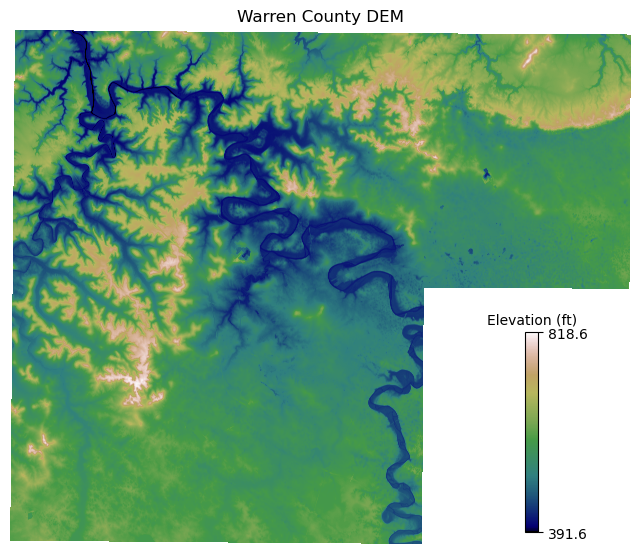

In [111]:
##### Warren County DEM
with rasterio.open(warren_dem_path) as dem:

    data = dem.read(1, masked=True)

    fig, ax = plt.subplots(figsize=(10,10))
    cax = ax.imshow(data, cmap='gist_earth')
    cbar = fig.colorbar(cax, ax=ax, ticks=None, shrink=0.3, aspect=15)
    cbar.set_ticks(ticks=[np.min(data), np.max(data)])
    cbar.ax.set_position(pos=[0.64, 0.25, 0.15, 0.2])
    cbar.ax.set_title('Elevation (ft)', fontdict={'fontsize':10, 'horizontalalignment':'center'})
    ax.set_axis_off()
    ax.set_title('Warren County DEM')
    plt.show()

### Elevation Histogram

In [112]:
def plot_dem_histogram(input_path, title=None):
    
    fig, ax = plt.subplots(figsize=(4,4))

    with rasterio.open(input_path) as dem:
        data = dem.read(1, masked=True)
        data = data.filled(np.nan)
        ax.hist(data.flatten(), bins=50, density=True, align='mid', linewidth=0.5, edgecolor='k')
        dem_min = str(round(np.nanmin(data), 1))
        dem_median = str(round(np.nanmedian(data), 1))
        dem_mean = str(round(np.nanmean(data), 1))
        dem_max = str(round(np.nanmax(data), 1))
        label=f"Min: {dem_min}\nMedian: {dem_median}\nMean: {dem_mean}\nMax: {dem_max}"
        ax.text(0.99, 0.99, label, ha='right', va='top', transform=ax.transAxes)
        ax.set_xlabel('Elevation (ft)')
        ax.set_ylabel('Density')
        ax.set_title(title, style='italic')
        plt.show()

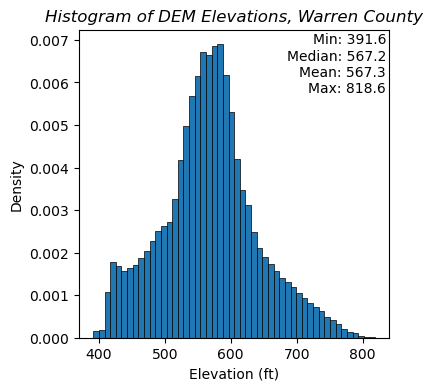

In [113]:
##### Warren County DEM Histogram

plot_dem_histogram(warren_dem_path, 'Histogram of DEM Elevations, Warren County')

### Surficial Geologic Map

In [114]:
def geo_symbology_colormap(input_metadata_path):
    """
    Function to create custom Matplotlib color map for integer-encoded string names.

    Parameters:
    input_metadata_path (str): Path to metadata .json with string field names and encoded integer values.

    Returns:
    geo_codes (dict): Dictionary of encoded integers (key) and original string field names (value).
    geo_codes_rgb (dict): Dictionary of encoded integers (key) and custom colors (value).
    
    """
    
    # open json metadata for string map unit (key) to integer code (value)
    with open(input_metadata_path, 'r') as meta:
        geo_names = json.load(meta)

    # define custom rgb color (value) mapping for geologic map unit names (key) from KGS standardized colors
    # NOTE: update with full list of colors from kgsmap
    geo_names_rgb = {'Qr':(176,172,214),
                     'af1':(99,101,102), 
                     'Qal':(253,245,164), 
                     'Qaf':(255,161,219), 
                     'Qat':(249,228,101), 
                     'Qc':(214,201,167), 
                     'Qca':(196,157,131)}
    
    # reverse mapping using encoded integer (key) and string map unit (value)
    geo_codes = {value:key for key, value in geo_names.items()}

    # color mapping to integer (key) and rgb percentage (rgb/255) (value)
    geo_codes_rgb = {geo_names[key]:tuple(v/255 for v in value) for key, value in geo_names_rgb.items()}

    return geo_codes, geo_codes_rgb

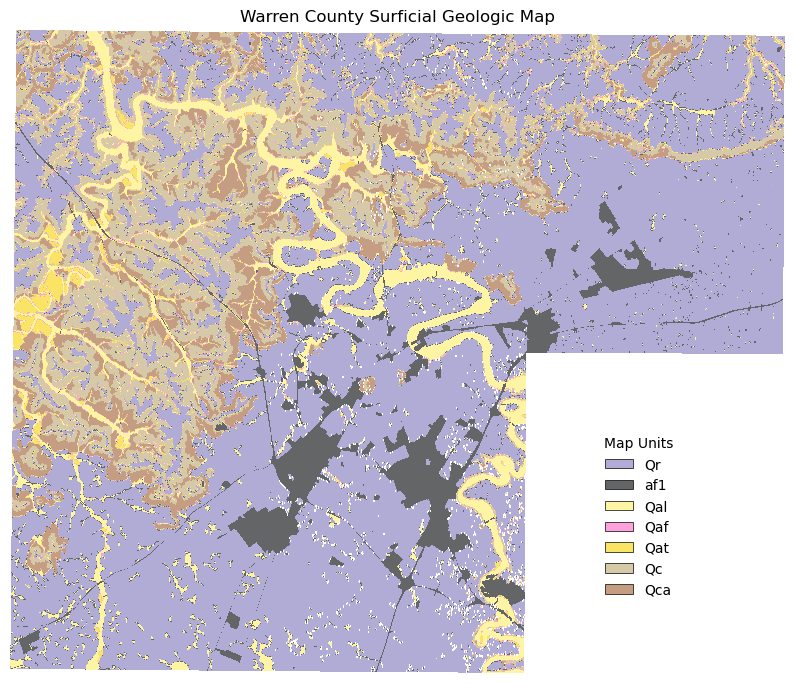

In [115]:
##### Warren County Surficial Geologic Map

# custom function for mapping string field names to encoded integers and KGS map colors
warren_codes, warren_rgb = geo_symbology_colormap(warren_geo_meta)

# open geologic map image and plot...
with rasterio.open(warren_geo_path) as geo:

    # read data (mask nodata values)
    data = geo.read(1, masked=True)

    # plot image...
    fig, ax = plt.subplots(figsize=(10,10))

    cmap = plt.matplotlib.colors.ListedColormap([warren_rgb[key] for key in warren_codes.keys()])
    ax.imshow(data, cmap=cmap)

    # create custom legend items
    handles = [mpatches.Patch(facecolor=warren_rgb[key], edgecolor='k', linewidth=0.5, label=warren_codes[key]) for key in warren_codes.keys()]
    ax.legend(handles=handles, bbox_to_anchor=(0.75, 0.1), loc='lower left', frameon=False, title='Map Units')

    # adjust plot elements
    ax.set_axis_off()
    ax.set_title('Warren County Surficial Geologic Map')
    plt.show()

### Class Distribution & Statistics

In [116]:
def total_class_area(input_geo_path, geo_codes_to_names_dict):
    """
    Function to return dictionary of geologic map symbol names (keys) and total geographic area of unique map unit classes:

    Parameters:
    input_geo_path (str): Path to geologic map image.
    geo_codes_to_names_dict (dict): Dictionary of encoded integers (keys) to geologic map names (values).

    Returns:
    names_areas (dict): Dictionary of geologic map names (keys) to total geographic areas (values).
    """
    
    # open geologic map image...
    with rasterio.open(input_geo_path) as geo:

        # read data as masked array (no data masked); compress to 1D array
        data = geo.read(1, masked=True).compressed()

        # get x and y pixel resolutions to calculate geographic area
        x_res, y_res = geo.res

        # get unique values (encoded integers) and count of pixels for each code
        codes, counts = np.unique(data, return_counts=True)

        # create dictionary of codes (keys) and pixel counts (values)
        codes_counts_dict = dict(zip(codes, counts))

        # calculate total geographic area for each unique map unit, then sort by area
        codes_areas = {int(key):(value * x_res * y_res) for key, value in codes_counts_dict.items()}
        codes_areas = dict(sorted(codes_areas.items(), key=lambda item: item[1], reverse=True))

        # ensure code-to-name keys are also int dtype, then map areas to key instead of code
        geo_codes_to_names_dict = {int(key):value for key, value in warren_codes.items()}
        names_areas = {geo_codes_to_names_dict[key]:value for key, value in codes_areas.items() if key in warren_codes.keys()}

        return names_areas

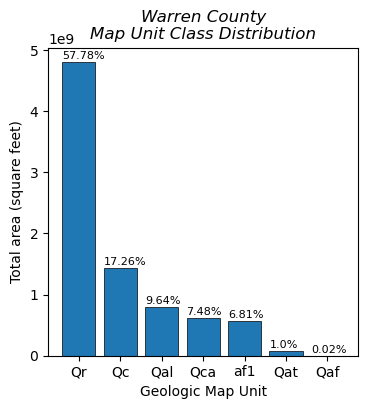

In [117]:
##### Warren County Geologic Map Unit Class Distribution

# custom function to get dictionary of geologic map unit name and total geographic area
names_areas = total_class_area(warren_geo_path, warren_codes)

##### plot class distributions (by total area in map)...
fig, ax = plt.subplots(figsize=(4,4))

# get data for bar chart...
x = range(1, len(names_areas) + 1)                          # number of classes
areas = list(names_areas.values())                          # list of total class geographic areas
percentages = [area / sum(areas) * 100 for area in areas]   # list of class area percentage
tick_labels = list(names_areas.keys())                      # list of map unit names for ticks

# plot bar chart
bars = ax.bar(x=x, height=areas, tick_label=tick_labels, align='center', linewidth=0.5, edgecolor='k')

# plot area percentage text on top of each bar
for bar, percent in zip(bars, percentages):
    yval = bar.get_height()
    ax.text(x=bar.get_x(), y=yval+float(0.05e9), s=str(round(percent, 2))+'%', fontsize=8)

# customize plot elements
ax.set_xlabel('Geologic Map Unit')
ax.set_ylabel('Total area (square feet)')
ax.set_title('Warren County\nMap Unit Class Distribution', style='italic')

plt.show()

In [118]:
def get_polygon_metrics(gdf, spatial_resolution=1):
    """Function to calculate area and minimum bounding box width and height. Optionally, can set spatial_resolution to convert geographic units to pixels.

    Parameters:
    gdf (dataframe): Geopandas GeoDataframe of polygons.
    spatial_resolution (int or float type): Spatial resolution of pixels in geographic units; default is 1, which yields the same as geographic units.

    Returns:
    gdf (dataframe): Geopandas GeoDataframe with new columns for area, min_box_width, and min_box_height.
    """
    # calculate area
    gdf['area'] = gdf['geometry'].area

    # get dataframe of minimum bounding box coordinates of each polygon
    bounds = gdf['geometry'].bounds

    # calculate minimum bounding box widths and heights for each polygon; np.abs to handle any c.r.s.
    gdf['min_box_width'] = np.abs(bounds['maxx'] - bounds['minx'])
    gdf['min_box_height'] = np.abs(bounds['maxy'] - bounds['miny'])

    if spatial_resolution != 1:
        gdf['min_box_width'] = gdf['min_box_width'] / spatial_resolution
        gdf['min_box_height'] = gdf['min_box_height'] / spatial_resolution

    return gdf

In [119]:
###### Warren County class statistics

# read GIS shapefile as geodataframe (easier to calculate class statistics than with raster)
gdf = gpd.read_file(warren_geo_shp_path)

# get area (geographic and minimum bounding box dimensions (width and height) for each polygon
gdf = get_polygon_metrics(gdf, spatial_resolution=5)

# calculate statistics for each class...
for unit in gdf['Symbol'].unique():

    # mask for class/geologic unit
    unit_mask = gdf['Symbol'] == unit

    # calculate statistics...
    min_area = gdf.loc[unit_mask, 'area'].min()          # minimum area
    median_area = gdf.loc[unit_mask, 'area'].median()    # media area
    mean_area = gdf.loc[unit_mask, 'area'].mean()        # mean area
    max_area = gdf.loc[unit_mask, 'area'].max()          # maximum area

    # get index for median area polygon
    median_idx = (gdf.loc[unit_mask, 'area'] - median_area).abs().idxmin()

    # print statistics...
    print(unit)
    print('Minimum Area (sq. ft.): ', round(min_area, 1))
    print('Median Area (sq. ft.): ', round(median_area, 1))
    print('Mean Area (sq. ft.): ', round(mean_area, 1))
    print('Maximum Area (sq. ft.): ', round(max_area, 1))

    # bounding box width and height for median area polygon
    print('Median Area Bounding Box Width (pixels): ', round(gdf.loc[median_idx, 'min_box_width'], 1))
    print('Median Area Bounding Box Height (pixels): ', round(gdf.loc[median_idx, 'min_box_height'], 1))
    
    print('\n')

Qr
Minimum Area (sq. ft.):  1584.8
Median Area (sq. ft.):  393155.3
Mean Area (sq. ft.):  9265508.9
Maximum Area (sq. ft.):  1237669732.3
Median Area Bounding Box Width (pixels):  189.4
Median Area Bounding Box Height (pixels):  158.6


af1
Minimum Area (sq. ft.):  2722.5
Median Area (sq. ft.):  43631.3
Mean Area (sq. ft.):  1679108.1
Maximum Area (sq. ft.):  349277696.7
Median Area Bounding Box Width (pixels):  168.3
Median Area Bounding Box Height (pixels):  47.2


Qal
Minimum Area (sq. ft.):  666.7
Median Area (sq. ft.):  47074.0
Mean Area (sq. ft.):  404524.1
Maximum Area (sq. ft.):  336669223.2
Median Area Bounding Box Width (pixels):  71.4
Median Area Bounding Box Height (pixels):  36.9


Qaf
Minimum Area (sq. ft.):  5000.5
Median Area (sq. ft.):  22793.3
Mean Area (sq. ft.):  36282.7
Maximum Area (sq. ft.):  235409.6
Median Area Bounding Box Width (pixels):  54.0
Median Area Bounding Box Height (pixels):  45.4


Qat
Minimum Area (sq. ft.):  11635.5
Median Area (sq. ft.):  244418

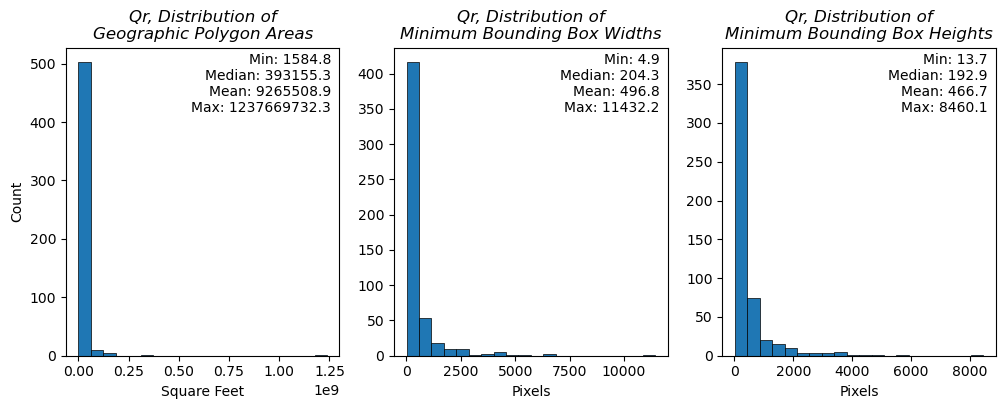

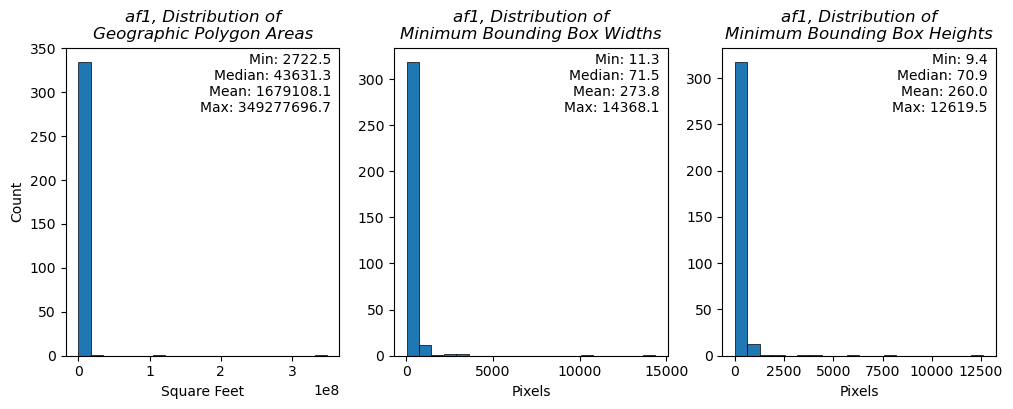

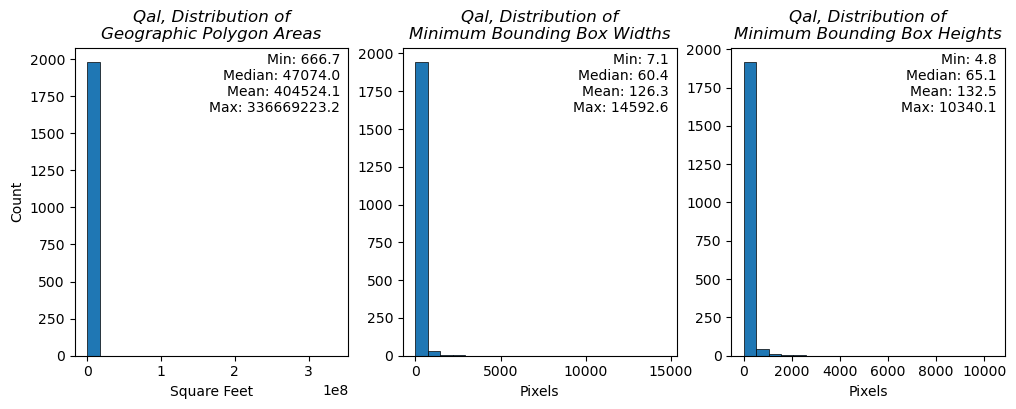

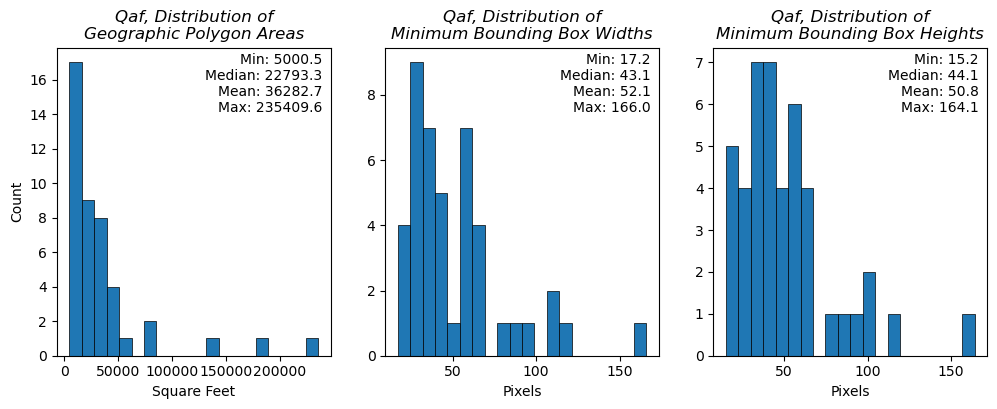

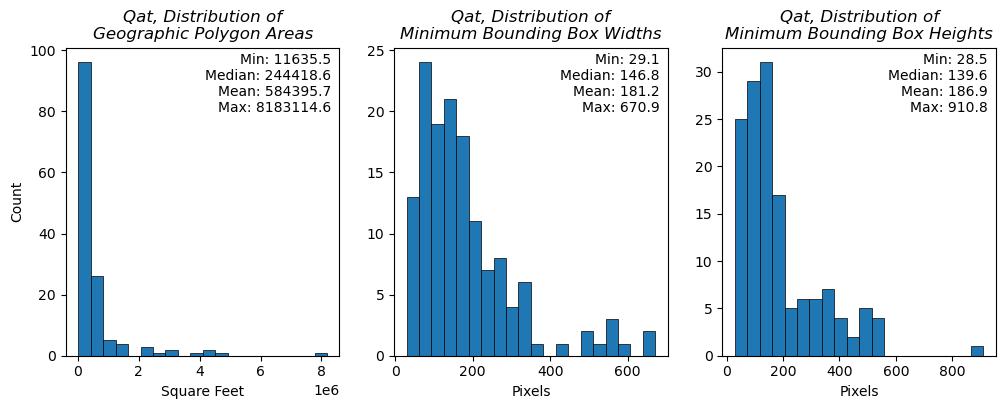

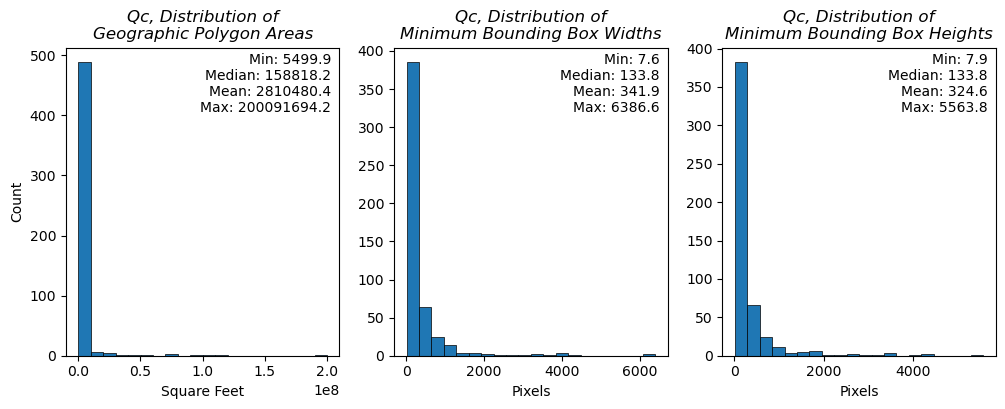

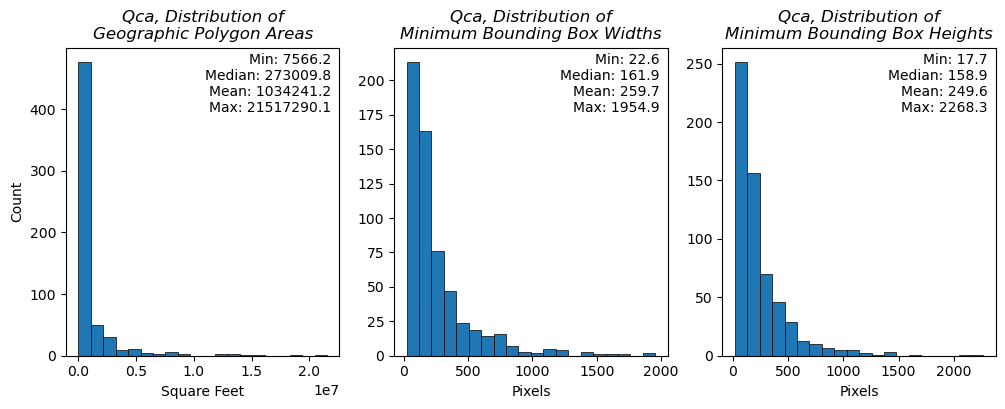

In [120]:
##### Histograms of Polygon Areas and Minimum Bounding Box Widths and Heights

# iterate through each class sorted by area...
for name in gdf['Symbol'].unique():

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

    # plot histogram for area and minimum bounding box widths and heights...
    for idx, field in enumerate(['area', 'min_box_width', 'min_box_height']):
        
        # mask for current unique map unit class
        name_mask = gdf['Symbol'] == name

        # get current column (area, min_box_width, or min_box_height)
        col = gdf.columns[4+idx]

        # calculate statistics for current class and column
        min_col = gdf.loc[name_mask, col].min()
        median_col = gdf.loc[name_mask, col].median()
        mean_col = gdf.loc[name_mask, col].mean()
        max_col = gdf.loc[name_mask, col].max()

        # plot histogram
        ax[idx].hist(gdf.loc[gdf['Symbol']==name, field], bins=20, align='mid', linewidth=0.5, edgecolor='k')

        # create label for statistics
        label = f"Min: {round(min_col,1)}\nMedian: {round(median_col,1)}\nMean: {round(mean_col,1)}\nMax: {round(max_col,1)}"

        # plot statistics as text on histogram
        ax[idx].text(x=0.97, y=0.79, s=label, transform=ax[idx].transAxes, horizontalalignment='right')

    # customize plot...
    ax[0].set_title(f"{name}, Distribution of\nGeographic Polygon Areas", style='italic')
    ax[0].set_xlabel('Square Feet')
    ax[0].set_ylabel('Count')

    ax[1].set_title(f"{name}, Distribution of\nMinimum Bounding Box Widths", style='italic')
    ax[1].set_xlabel('Pixels')
    
    ax[2].set_title(f"{name}, Distribution of\nMinimum Bounding Box Heights", style='italic')
    ax[2].set_xlabel('Pixels')

    plt.show()

### Random Examples

In [52]:
from rasterio.windows import Window

def extract_patch(geotiff_path, centroid, patch_size):

    with rasterio.open(geotiff_path) as src:
        
        # Convert centroid coordinates to row and column
        row, col = src.index(centroid.x, centroid.y)
        
        # Calculate the window size
        half_size = patch_size // 2
        window = Window(col - half_size, row - half_size, patch_size, patch_size)
        
        # Calculate the full patch with nodata values
        full_patch = np.full((patch_size, patch_size), src.nodata, dtype=src.dtypes[0])
        
        # Calculate the region of interest inside the source image
        left = max(0, col - half_size)
        right = min(src.width, col + half_size)
        top = max(0, row - half_size)
        bottom = min(src.height, row + half_size)
        
        # Calculate the corresponding positions in the full patch
        patch_left = half_size - (col - left)
        patch_right = patch_left + (right - left)
        patch_top = half_size - (row - top)
        patch_bottom = patch_top + (bottom - top)
        
        # Read the valid part of the image
        window = Window(left, top, right - left, bottom - top)
        patch_data = src.read(1, window=window)
        
        # Insert the valid data into the full patch array
        full_patch[patch_top:patch_bottom, patch_left:patch_right] = patch_data
        
        # Mask the nodata values
        full_patch = np.ma.masked_equal(full_patch, src.nodata)

        # Get the transform for the patch
        transform = src.window_transform(window)
        
        return full_patch, transform

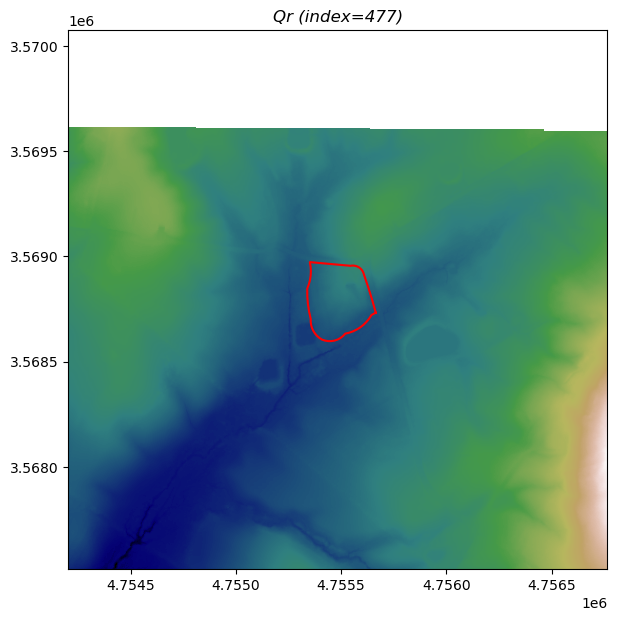

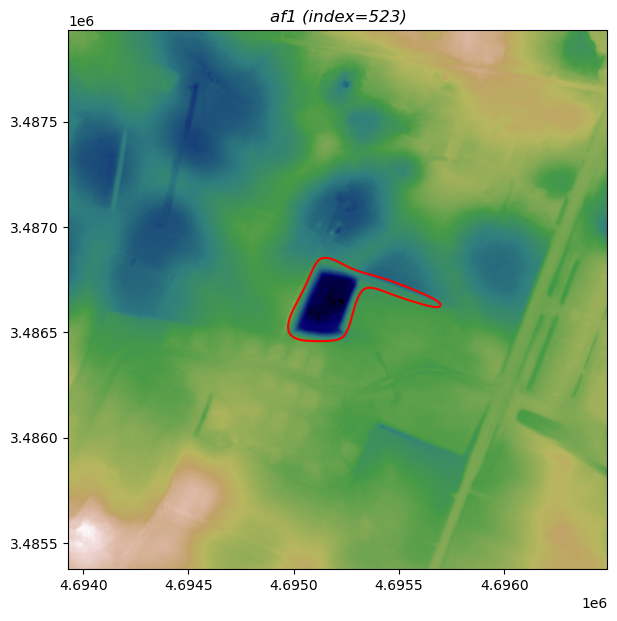

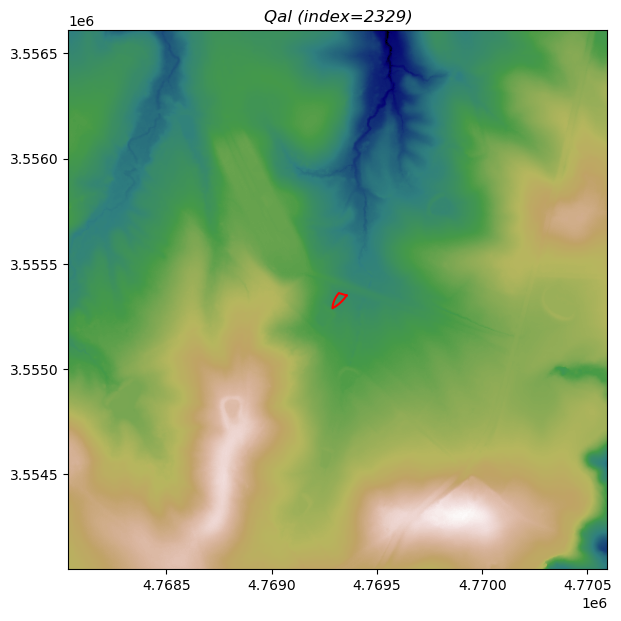

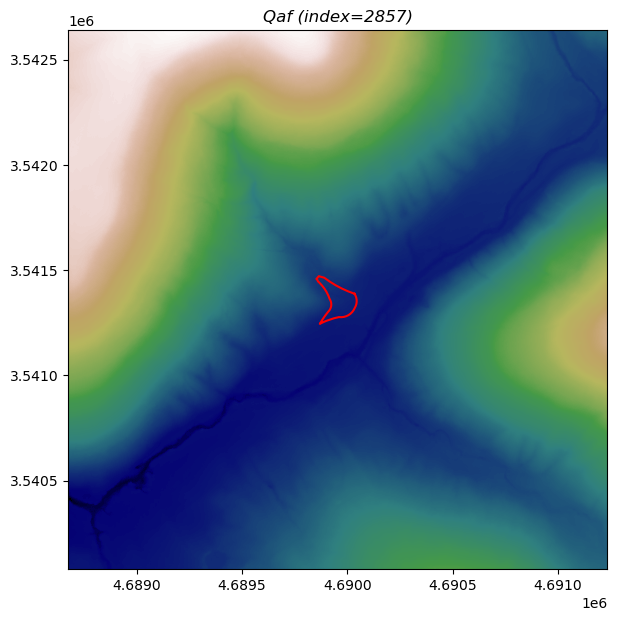

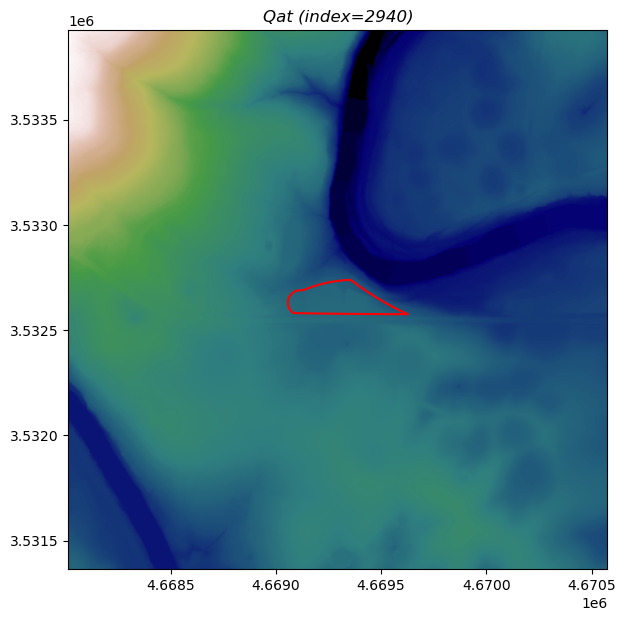

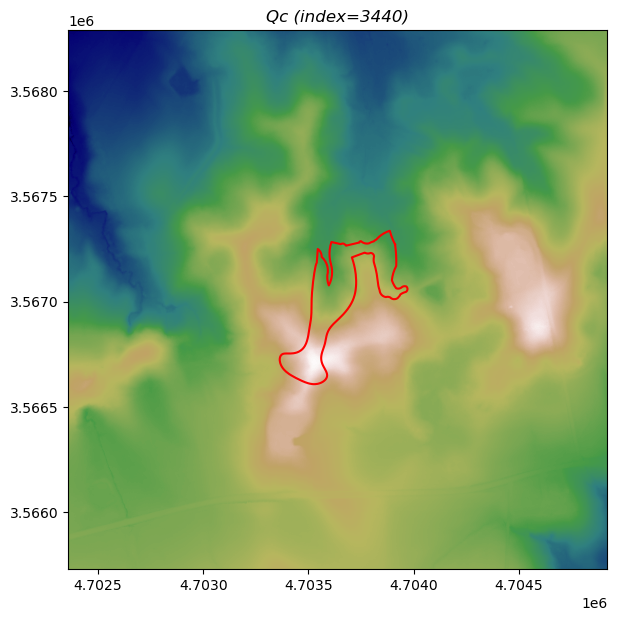

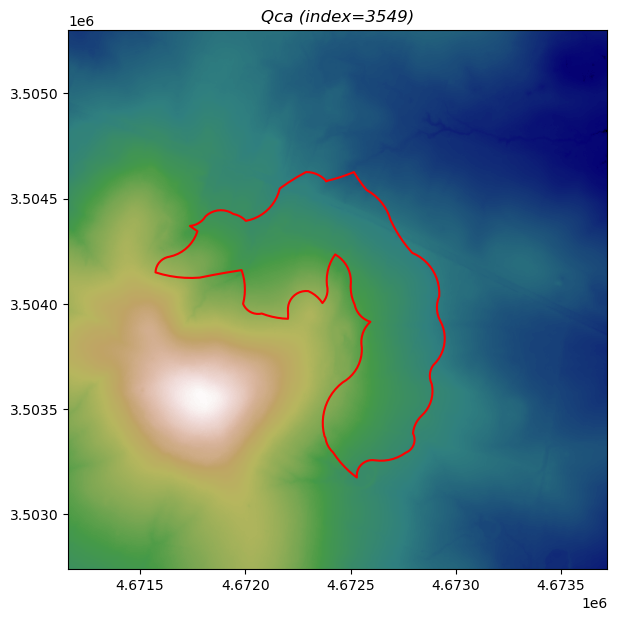

In [62]:
##### Plot Random Polygons and DEM of Specified Size

# choose patch size (in pixels)
patch_size = 512

# read geologic map as geodataframe
gdf = gpd.read_file(warren_geo_shp_path)

# iterate through all unique geologic map unit classes
for name in gdf['Symbol'].unique():

    # get subset gdf for specific class
    gdf_subset = gdf[gdf['Symbol'] == name].copy()

    # generate random index of subset
    random_idx = rng.choice(gdf_subset.index, size=1)[0]

    # get centroid of randomly chosen polygon
    centroid = gdf.loc[random_idx, 'geometry'].centroid

    # call custom function to extract patch of dem of specified size centered on chosen polygon
    patch, transform = extract_patch(warren_dem_path, centroid, patch_size)

    # calculate extent of patch in geographic coordinates
    minx = transform[2]
    maxx = transform[2] + transform[0] * patch.shape[1]
    miny = transform[5] + transform[4] * patch.shape[0]
    maxy = transform[5]

    # plot DEM patch and outline of polygon...
    fig, ax = plt.subplots(figsize=(7,7))

    # use Rasterio.plot.show to plot DEM patch in geographic coordinates
    show(patch, ax=ax, transform=transform, cmap='gist_earth')

    # get polygon geometry
    poly = gdf.geometry[random_idx]

    # get exterior outline of polygon
    x, y = poly.exterior.xy

    # plot outline of polygon
    ax.plot(x, y, color='red')

    # get polygon name/Symbol
    poly_name = gdf.loc[random_idx, 'Symbol']

    # set plot title as polygon symbol name and index number
    ax.set_title(f"{poly_name} (index={random_idx})", style='italic')

    # set x and y limits of plot using extent of DEM patch (always same size, unlike polygons)
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    plt.show()

## Hardin County

### DEM

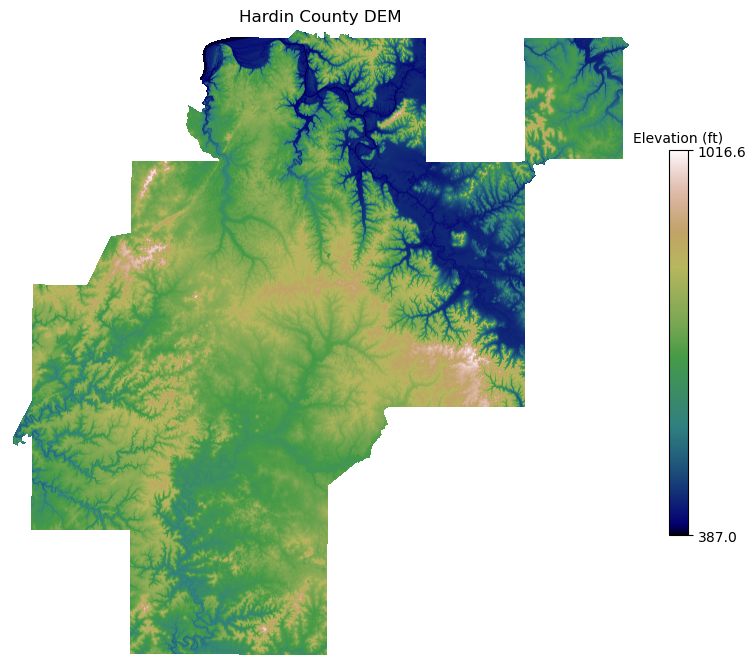

In [14]:
##### Hardin County DEM

with rasterio.open(hardin_dem_path) as dem:

    data = dem.read(1, masked=True)

    fig, ax = plt.subplots(figsize=(10,10))
    cax = ax.imshow(data, cmap='gist_earth')
    cbar = fig.colorbar(cax, shrink=0.5, ticks=None)
    cbar.set_ticks(ticks=[np.min(data), np.max(data)])
    cbar.ax.set_title('Elevation (ft)', fontdict={'fontsize':10, 'horizontalalignment':'center'})
    ax.set_axis_off()
    ax.set_title('Hardin County DEM')
    plt.show()

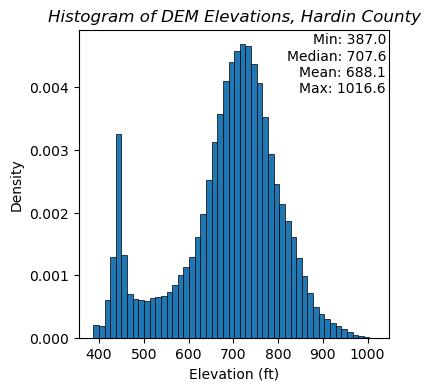

In [33]:
##### Hardin County DEM Histogram

plot_dem_histogram(hardin_dem_path, 'Histogram of DEM Elevations, Hardin County')

In [ ]:
##### Aggregated statistics of Geologic Map Unit by Area

input_shapefile_path = r'../data/warren/geo_warren.shp'

gdf = gpd.read_file(input_shapefile_path)

gdf['area'] = gdf['geometry'].area

gdf.groupby('Symbol')['area'].agg(['min', 'mean', 'max', 'sum'])

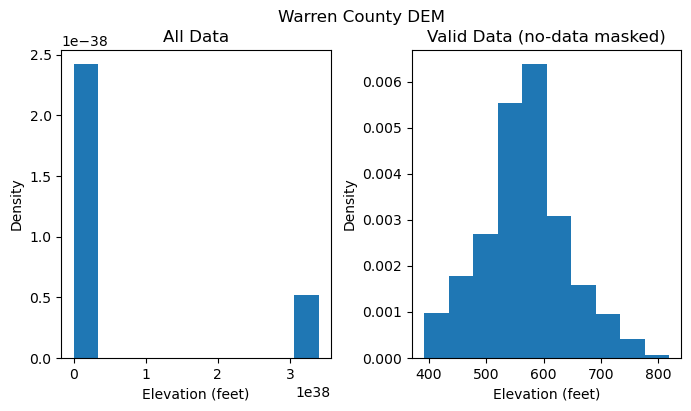

In [32]:
##### plot histograms of DEM...

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
plt.subplots_adjust(wspace=0.3)

with rasterio.open(warren_dem_path) as dem:

    all_data = dem.read(1)
    masked_data = dem.read(1, masked=True)
    
    ax[0].hist(all_data.flatten(), density=True)
    ax[0].set_title('All Data')
    ax[1].hist(masked_data.flatten(), density=True)
    ax[1].set_title('Valid Data (no-data masked)')

    for idx in range(len(ax)):
        ax[idx].set_xlabel('Elevation (feet)')
        ax[idx].set_ylabel('Density')

    plt.suptitle('Warren County DEM')
    plt.show()

In [ ]:
##### Plot Class Distributions of Geologic Map

with rasterio.open(warren_geo_path) as geo:
    
    labels = geo.read(1)

    unique_labels, counts = np.unique(labels, return_counts=True)

    class_distribution = dict(zip(unique_labels, counts))

    plt.bar(x=range(len(class_distribution)), 
            height=list(class_distribution.values()), 
            tick_label=list(class_distribution.keys()), 
            align='center')

    plt.title('Warren County Geologic Label Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count (pixels)')
    plt.show()

### Surficial Geologic Map

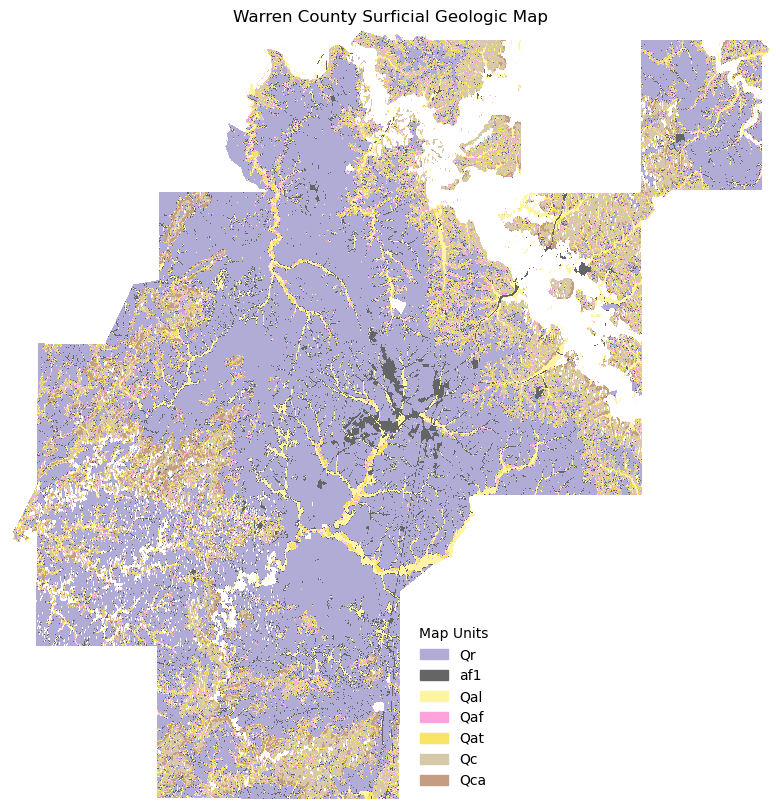

In [38]:
##### Hardin County Geologic Map

# open geologic map image and plot...
with rasterio.open(hardin_geo_path) as geo:

    # read data (mask nodata values)
    data = geo.read(1, masked=True)

    # plot image...
    fig, ax = plt.subplots(figsize=(10,10))

    # custom 
    cmap = plt.matplotlib.colors.ListedColormap([warren_rgb[key] for key in warren_codes.keys()])
    ax.imshow(data, cmap=cmap)

    # create custom legend items
    handles = [mpatches.Patch(color=warren_rgb[key], label=warren_codes[key]) for key in warren_codes.keys()]
    ax.legend(handles=handles, bbox_to_anchor=(0.52, 0), loc='lower left', frameon=False, title='Map Units')

    # adjust plot elements
    ax.set_axis_off()
    ax.set_title('Warren County Surficial Geologic Map')
    plt.show()

In [42]:
##### Keep only 7 Geologic Units from Warren County

# open warren county json metadata
with open(warren_geo_meta, 'r') as warren_meta:
    warren_geo_labels = json.load(warren_meta)



# open hardin county json metadata
with open(hardin_geo_meta, 'r') as hardin_meta:
    hardin_geo_labels = json.load(hardin_meta)



hardin_integers_mask = list(hardin_geo_labels.values())

for warren_label in warren_geo_labels.keys():

    hardin_integers_mask.remove(hardin_geo_labels[warren_label])



with rasterio.open(hardin_geo_path) as geo:

    data = geo.read(1)
    nodata_value = geo.nodata
    meta = geo.meta

    for integer in hardin_integers_mask:

        data[data == integer] = nodata_value

    hardin_geo_mask_path = r'../data/hardin/geo_hardin_mask.tif'

    with rasterio.open(hardin_geo_mask_path, 'w', **meta) as dst:

        dst.write(data, 1)

In [68]:
##### Warren County Integer-to-Symbol Encoding/Decoding

# open json metadata for map unit to integer mapping
with open(hardin_geo_meta, 'r') as geo_meta:
    geo_labels = json.load(geo_meta)

# custom rgb colors for warren county map units
geo_labels_rgb = {'Qr':(176,172,214), 
                  'af1':(99,101,102), 
                  'Qal':(253,245,164), 
                  'Qaf':(255,161,219), 
                  'Qat':(249,228,101), 
                  'Qc':(214,201,167), 
                  'Qca':(196,157,131)}

# reverse mapping as integer (key) to map unit (value)
geo_ints = {geo_labels[key]:key for key in geo_labels_rgb.keys()}



# reverse color mapping to integer and rgb percentage (rgb/255)
geo_ints_colors = {geo_labels[key]:tuple(v/255 for v in value) for key, value in geo_labels_rgb.items()}

# create custom color map
cmap = plt.matplotlib.colors.ListedColormap([geo_ints_colors[key] for key in geo_ints.keys()])

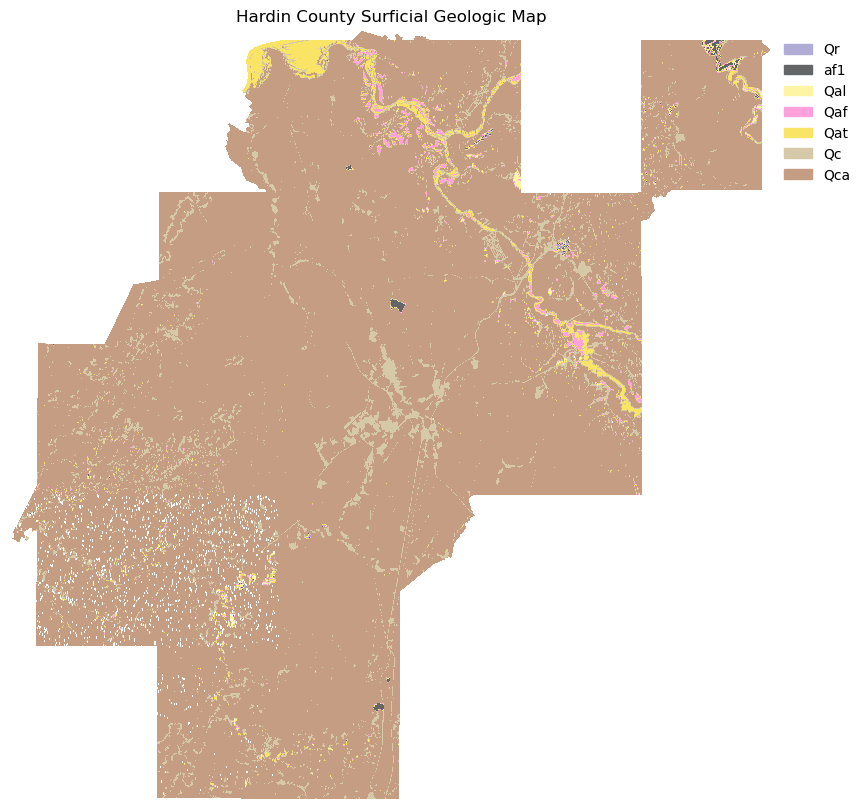

In [75]:
##### Hardin County Geologic Map

# open geologic map image and plot...
with rasterio.open(hardin_geo_path) as geo:

    # read data (mask nodata values)
    data = geo.read(1, masked=True)

    # plot image...
    fig, ax = plt.subplots(figsize=(10,10))
    cax = ax.imshow(data, cmap=cmap)

    # create custom legend items
    handles = [mpatches.Patch(color=geo_ints_colors[key], label=geo_ints[key]) for key in geo_ints.keys()]
    ax.legend(handles=handles, bbox_to_anchor=(1,1), loc='upper left', frameon=False)

    # adjust plot elements
    ax.set_axis_off()
    ax.set_title('Hardin County Surficial Geologic Map')
    plt.show()

In [79]:
input_shapefile_path = r'../data/hardin/geo_hardin.shp'

gdf = gpd.read_file(input_shapefile_path)

gdf['area'] = gdf['geometry'].area

for unit in gdf['Symbol'].unique():
    print(unit)
    print('Minimum Area (sq. ft.): ', round(gdf.loc[gdf['Symbol']==unit, 'area'].min(), 2))
    print('Mean Area (sq. ft.): ', round(gdf.loc[gdf['Symbol']==unit, 'area'].mean(), 2))
    print('Maximum Area (sq. ft.): ', round(gdf.loc[gdf['Symbol']==unit, 'area'].max(), 2))
    print('\n')

Qot2
Minimum Area (sq. ft.):  5954.62
Mean Area (sq. ft.):  42242.99
Maximum Area (sq. ft.):  244780.92


Qapc
Minimum Area (sq. ft.):  34055.33
Mean Area (sq. ft.):  330395.24
Maximum Area (sq. ft.):  1432015.67


Qha
Minimum Area (sq. ft.):  10434.11
Mean Area (sq. ft.):  1476830.95
Maximum Area (sq. ft.):  4599906.52


Qalo
Minimum Area (sq. ft.):  29653.37
Mean Area (sq. ft.):  634723.68
Maximum Area (sq. ft.):  1706748.99


af2
Minimum Area (sq. ft.):  349240.63
Mean Area (sq. ft.):  3895266.34
Maximum Area (sq. ft.):  10373973.67


Qlt
Minimum Area (sq. ft.):  11426.77
Mean Area (sq. ft.):  1182532.03
Maximum Area (sq. ft.):  6065096.22


Qls
Minimum Area (sq. ft.):  5424.65
Mean Area (sq. ft.):  63323.87
Maximum Area (sq. ft.):  650303.0


PZ
Minimum Area (sq. ft.):  9387.27
Mean Area (sq. ft.):  60769.68
Maximum Area (sq. ft.):  1737693.91


Qat3
Minimum Area (sq. ft.):  10632.54
Mean Area (sq. ft.):  571997.05
Maximum Area (sq. ft.):  9027750.63


Qaf
Minimum Area (sq. ft.):  

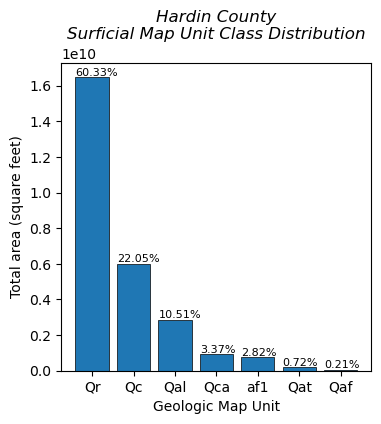

In [80]:
##### Hardin County Geologic Map Unit Class Distribution

fig, ax = plt.subplots(figsize=(4,4))

with rasterio.open(hardin_geo_mask_path) as geo:

    data = geo.read(1, masked=True).compressed()
    x_res, y_res = geo.res

    int_labels, pixel_counts = np.unique(data, return_counts=True)

    int_counts = dict(zip(int_labels, pixel_counts))

    label_areas = {geo_ints[key]:int_counts[key]*x_res*y_res for key in int_counts.keys()}

    label_areas = dict(sorted(label_areas.items(), key=lambda item: item[1], reverse=True))

    x = range(1, len(label_areas)+1)
    areas = list(label_areas.values())
    percentages = [x/sum(label_areas.values())*100 for x in label_areas.values()]
    tick_labels = [x for x in label_areas.keys()]

    bars = ax.bar(x=x, height=areas, tick_label=tick_labels, align='center', linewidth=0.5, edgecolor='k')


    for bar, per in zip(bars, percentages):
        yval = bar.get_height()
        ax.text(x=bar.get_x(), y=yval+float(0.08e9), s=str(round(per, 2))+'%', fontsize=8)


    ax.set_xlabel('Geologic Map Unit')
    ax.set_ylabel('Total area (square feet)')
    ax.set_title('Hardin County\nSurficial Map Unit Class Distribution', style='italic')

    plt.show()

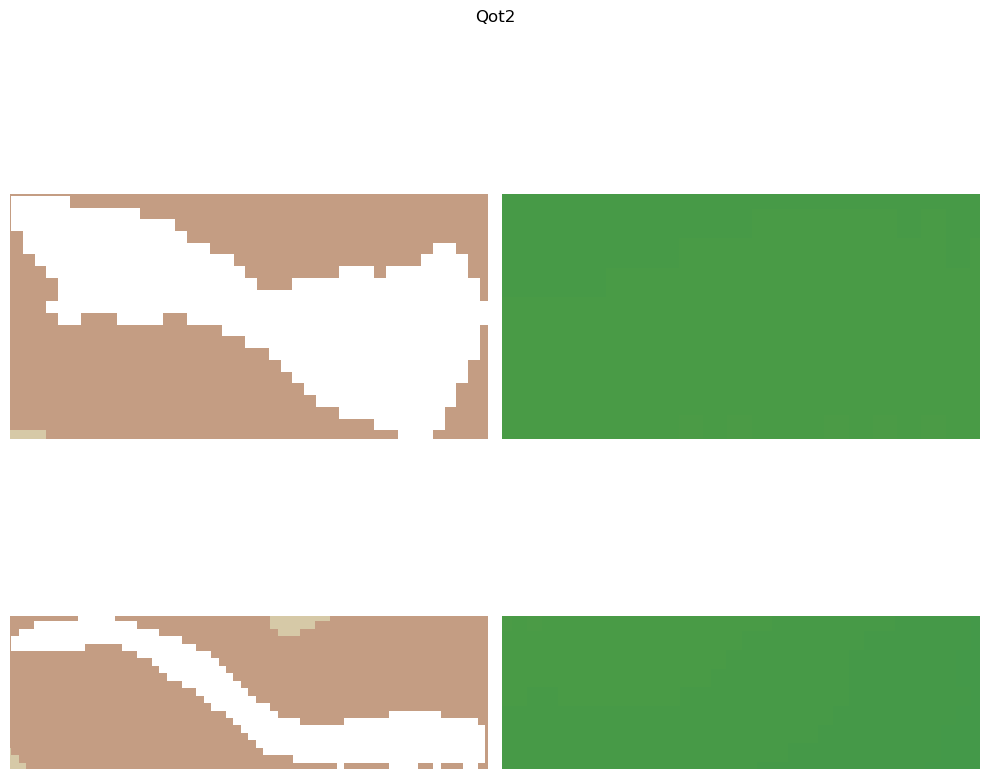

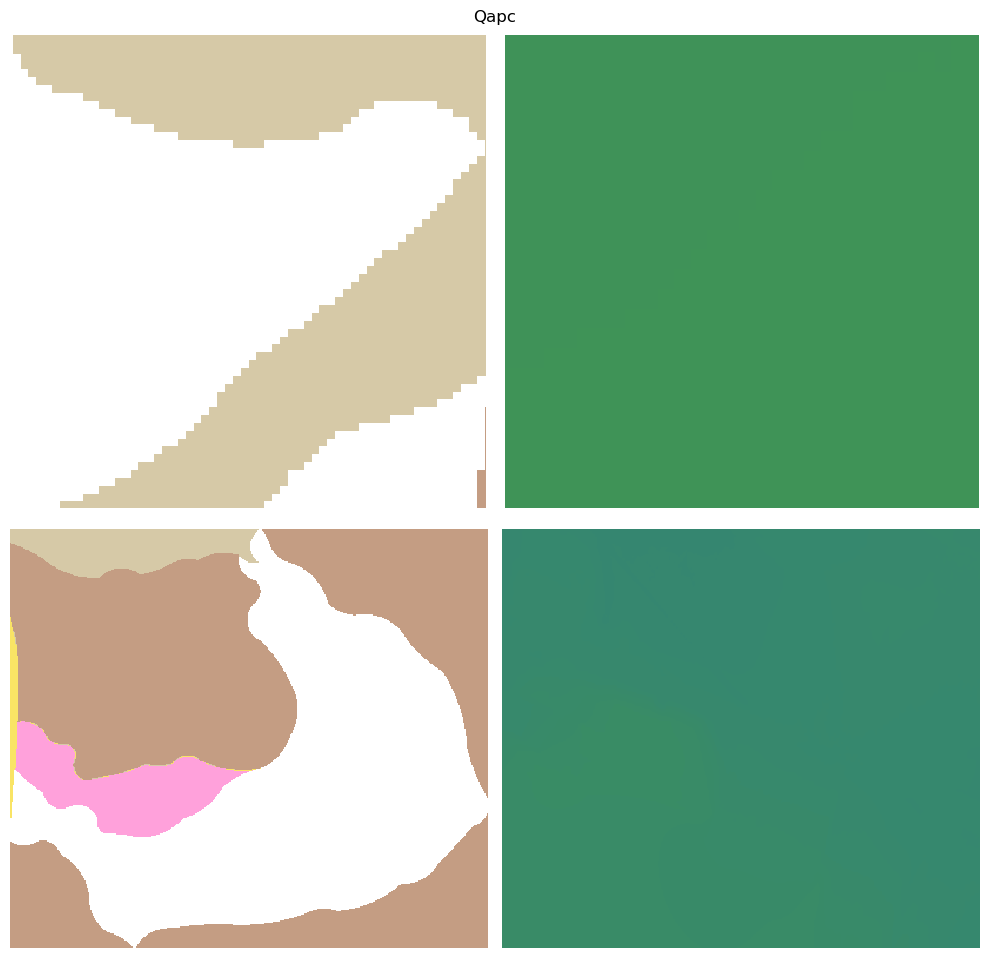

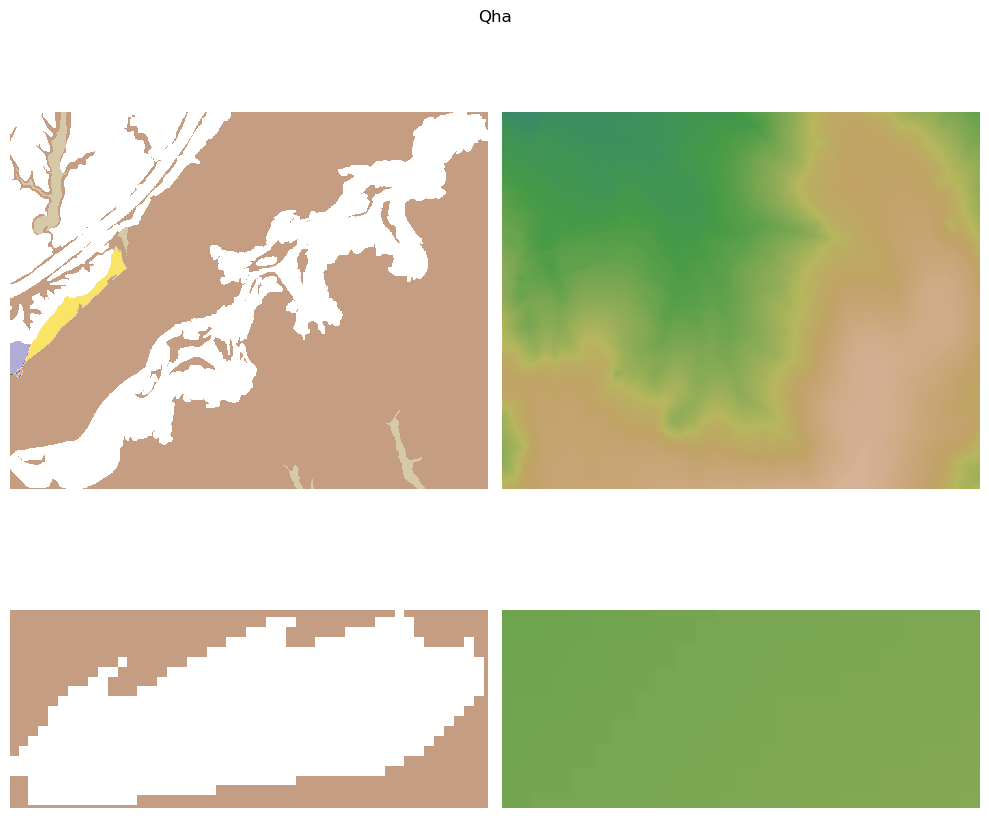

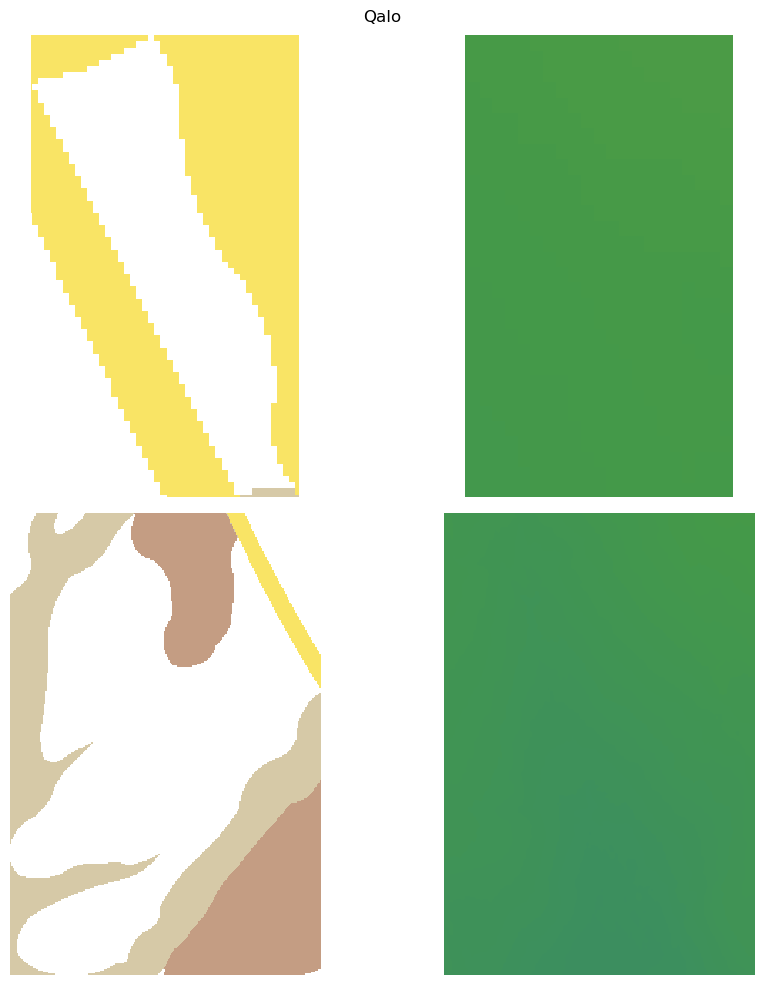

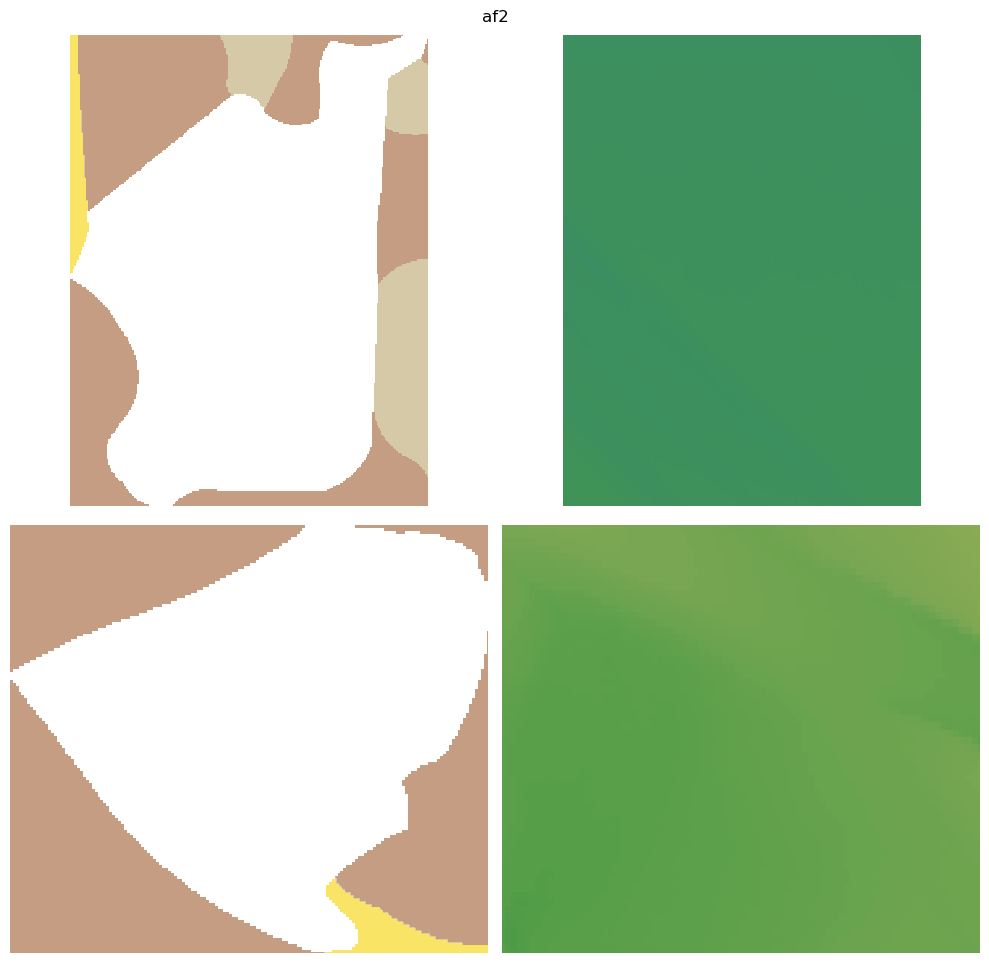

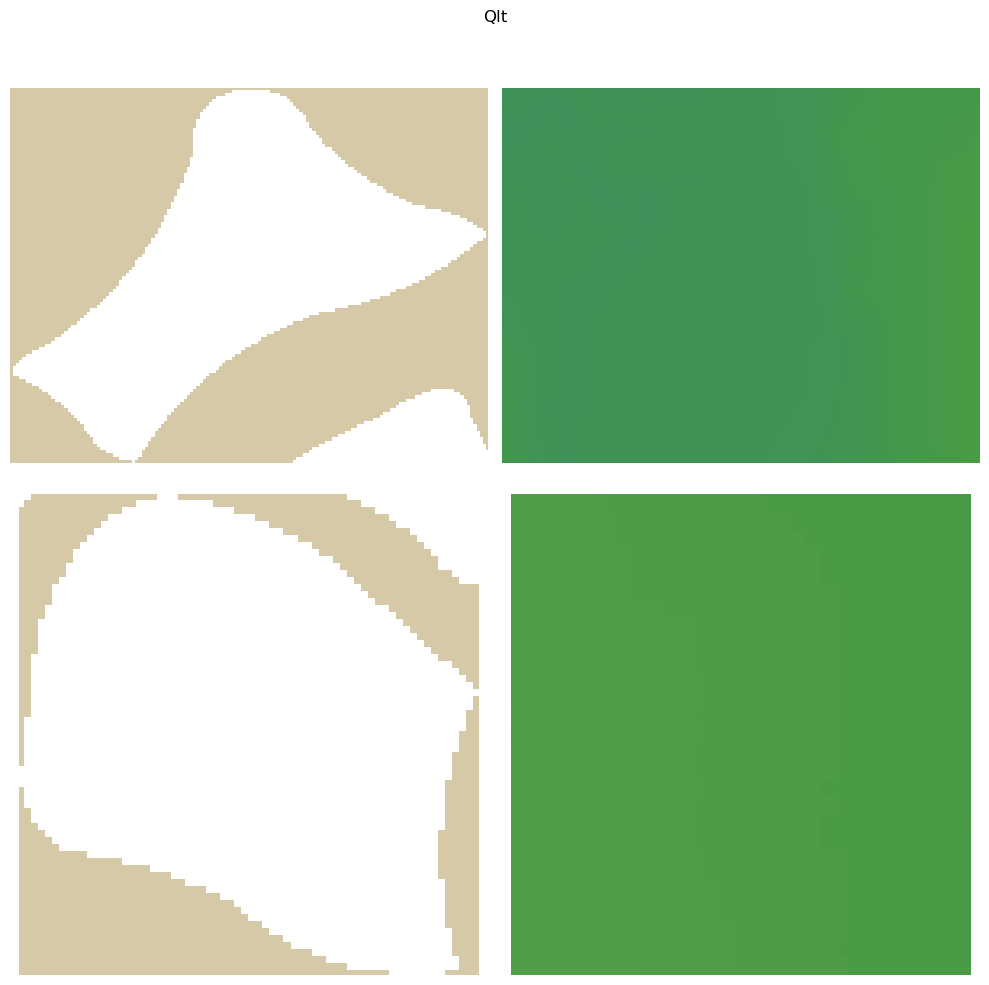

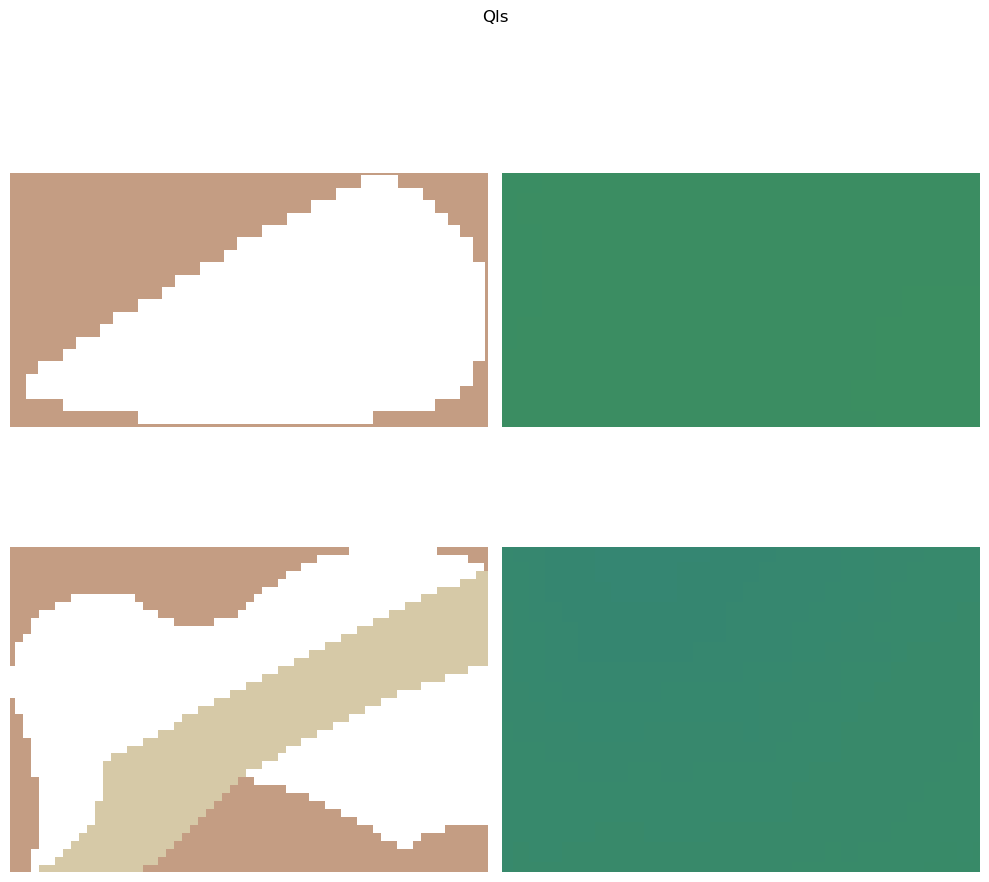

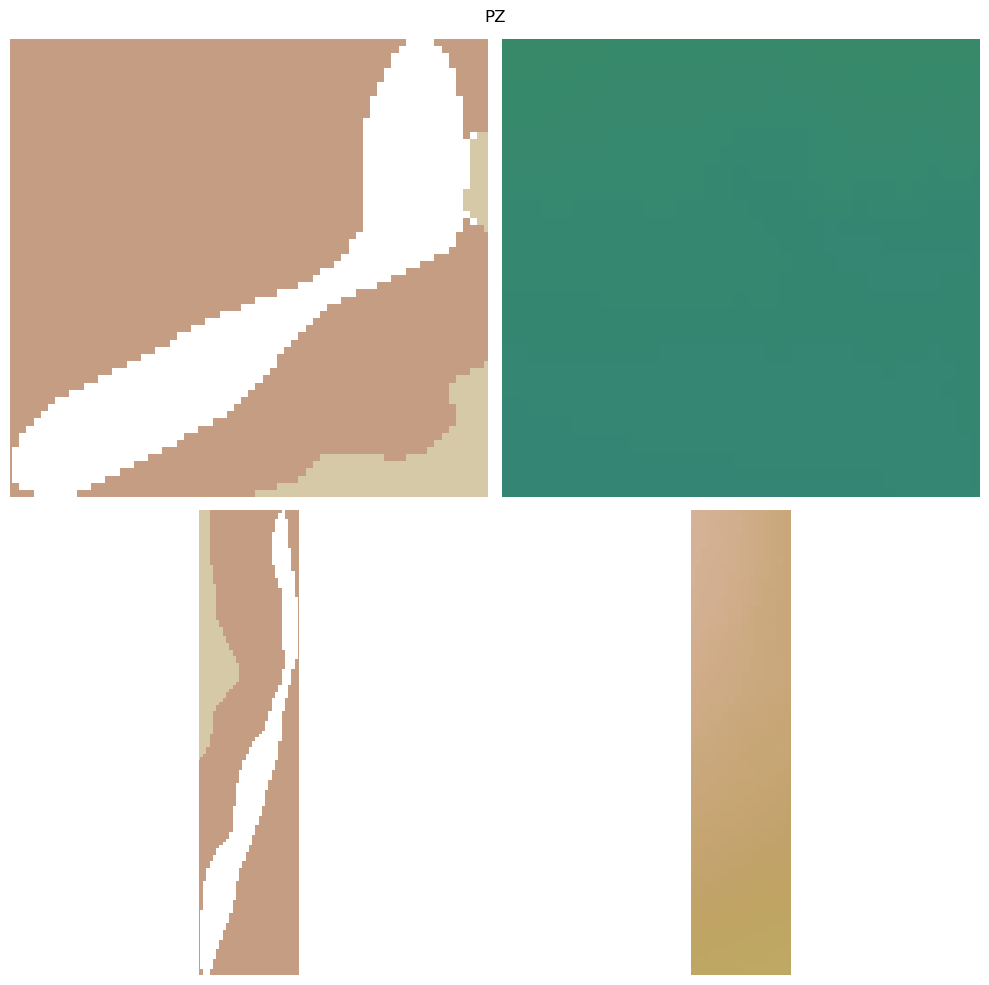

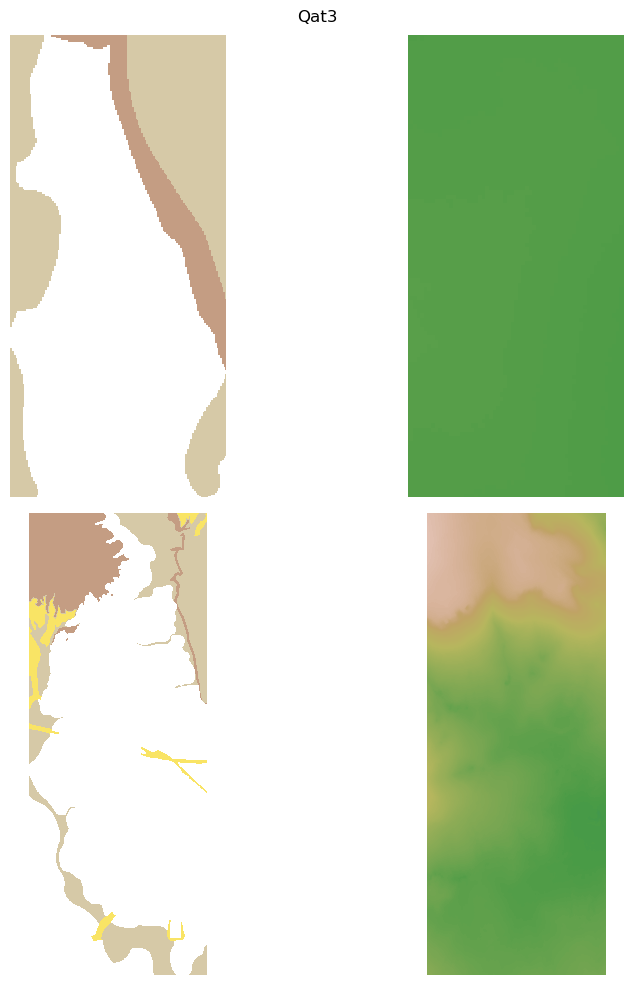

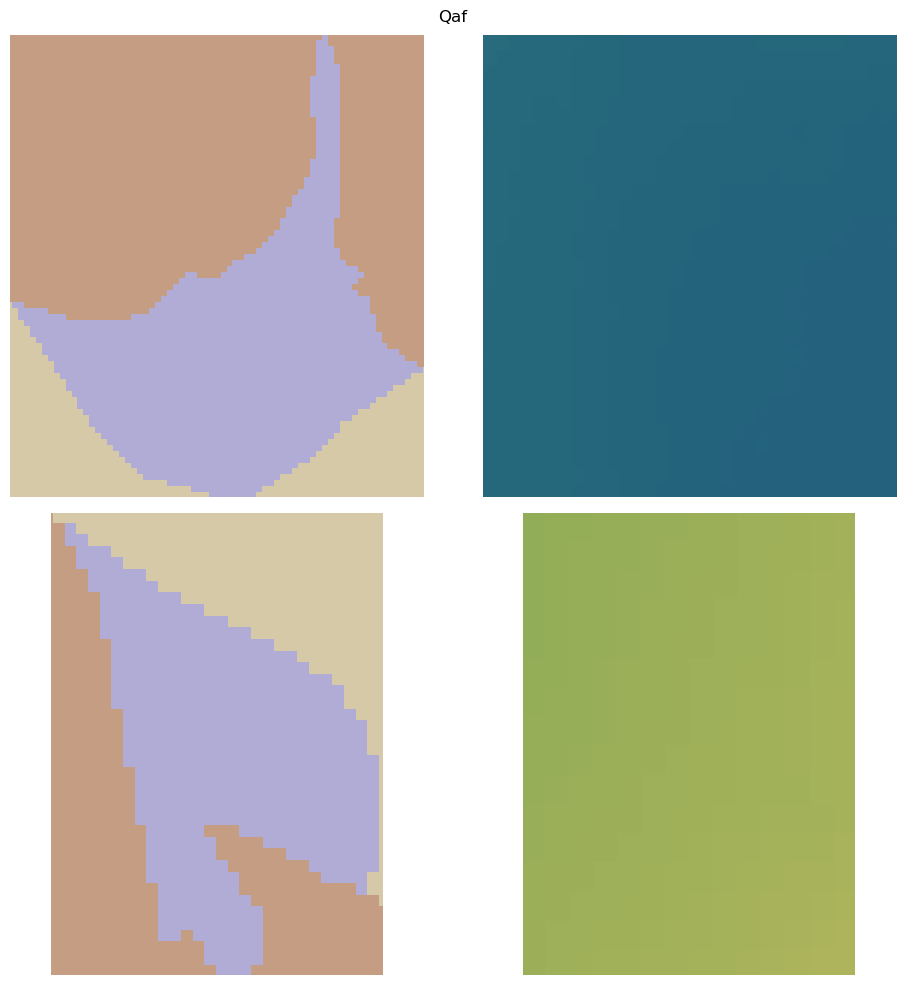

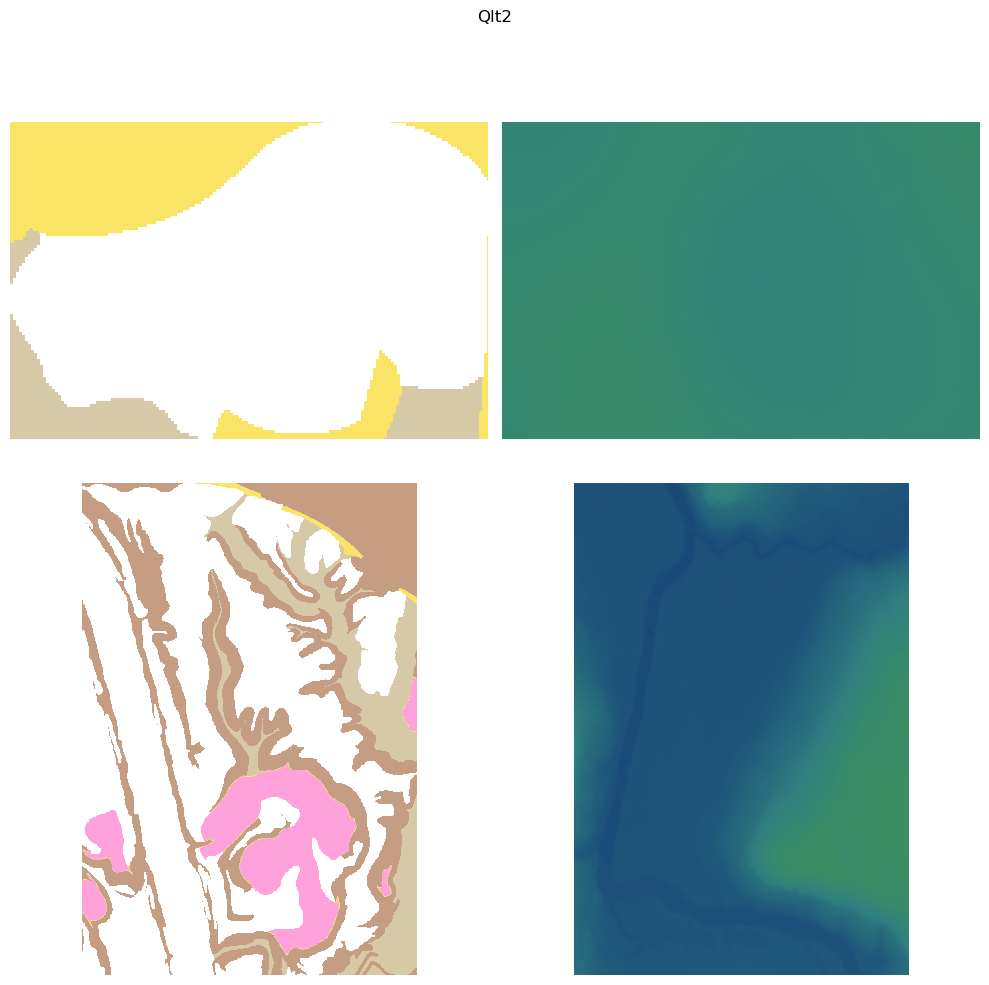

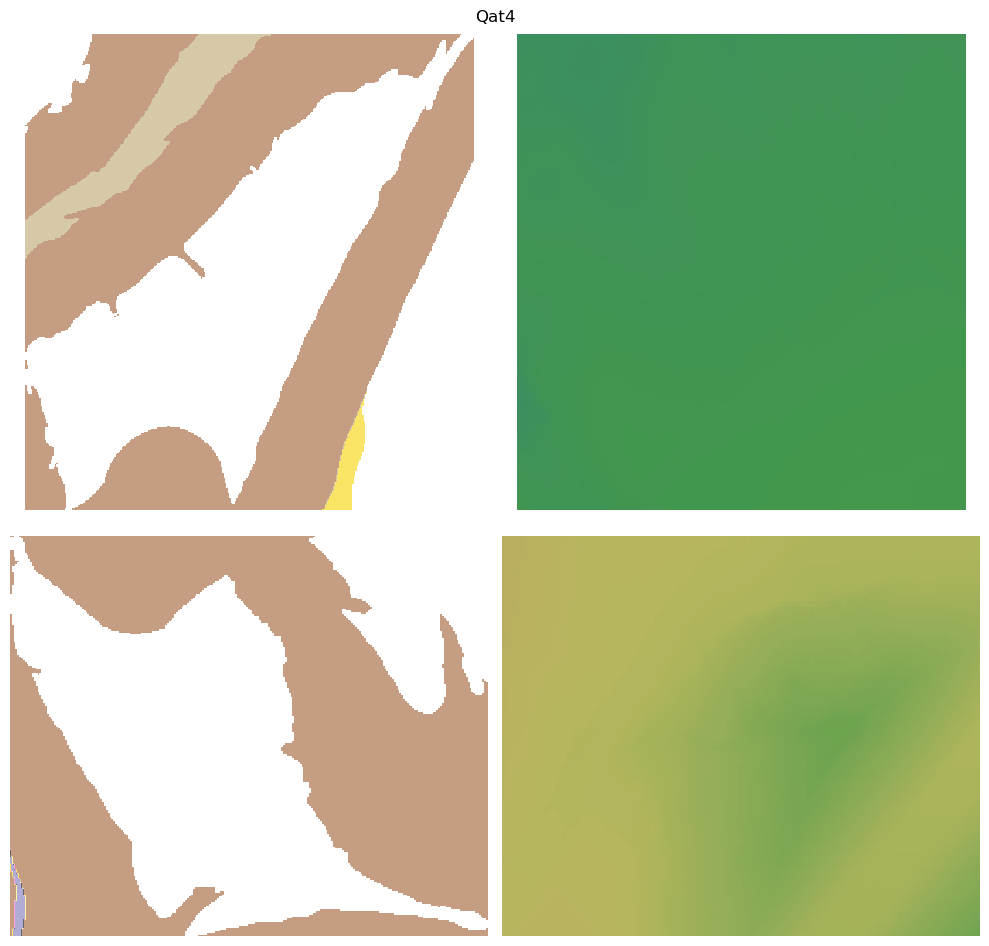

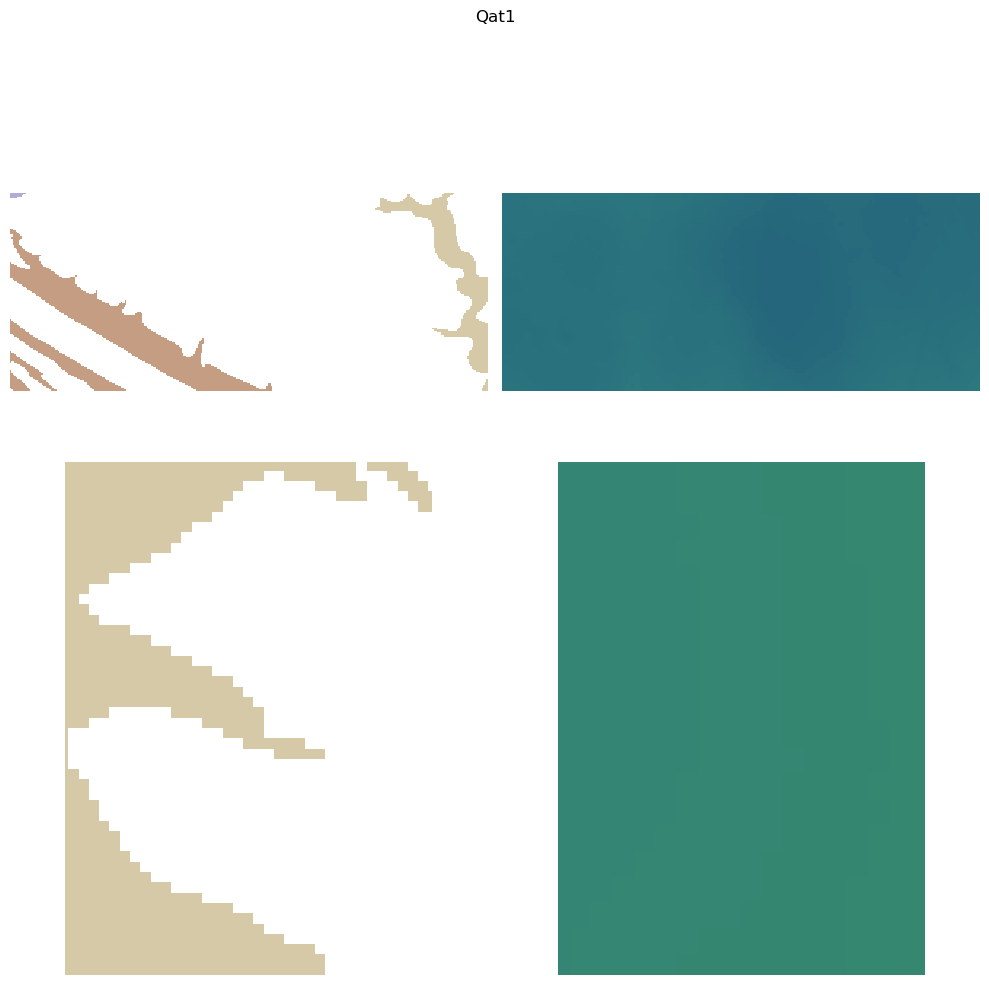

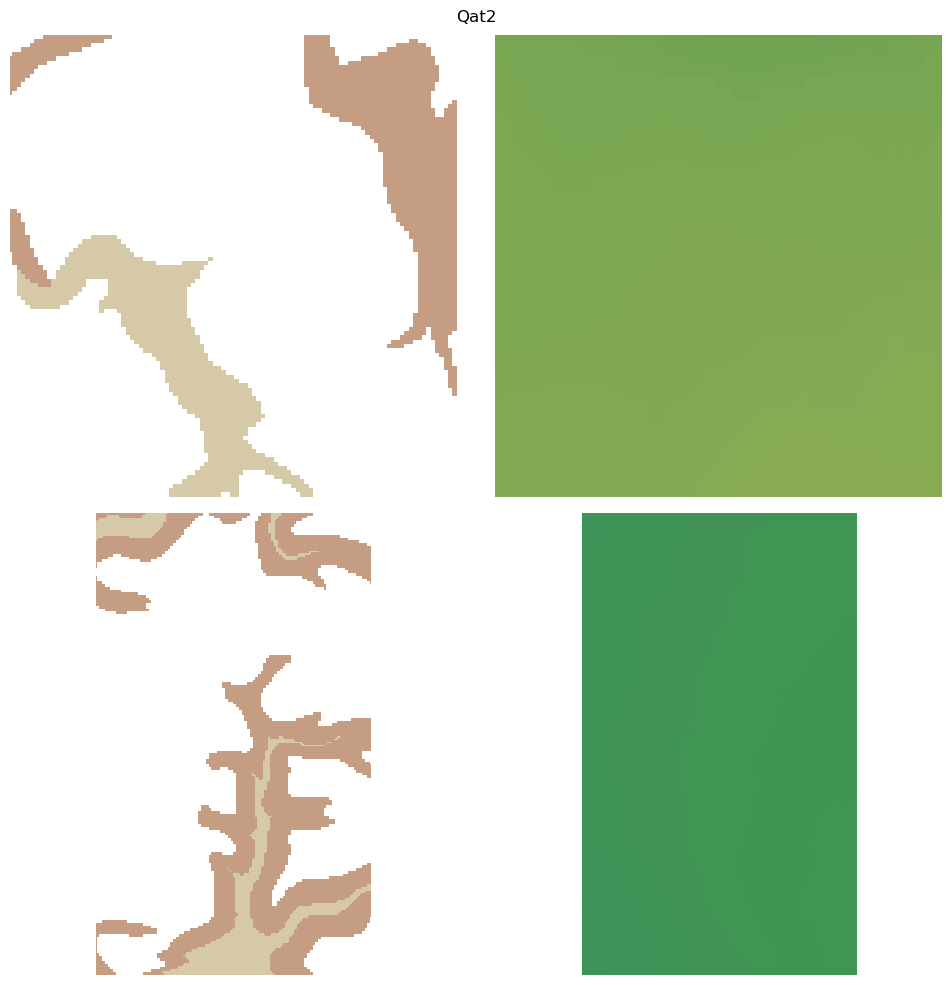

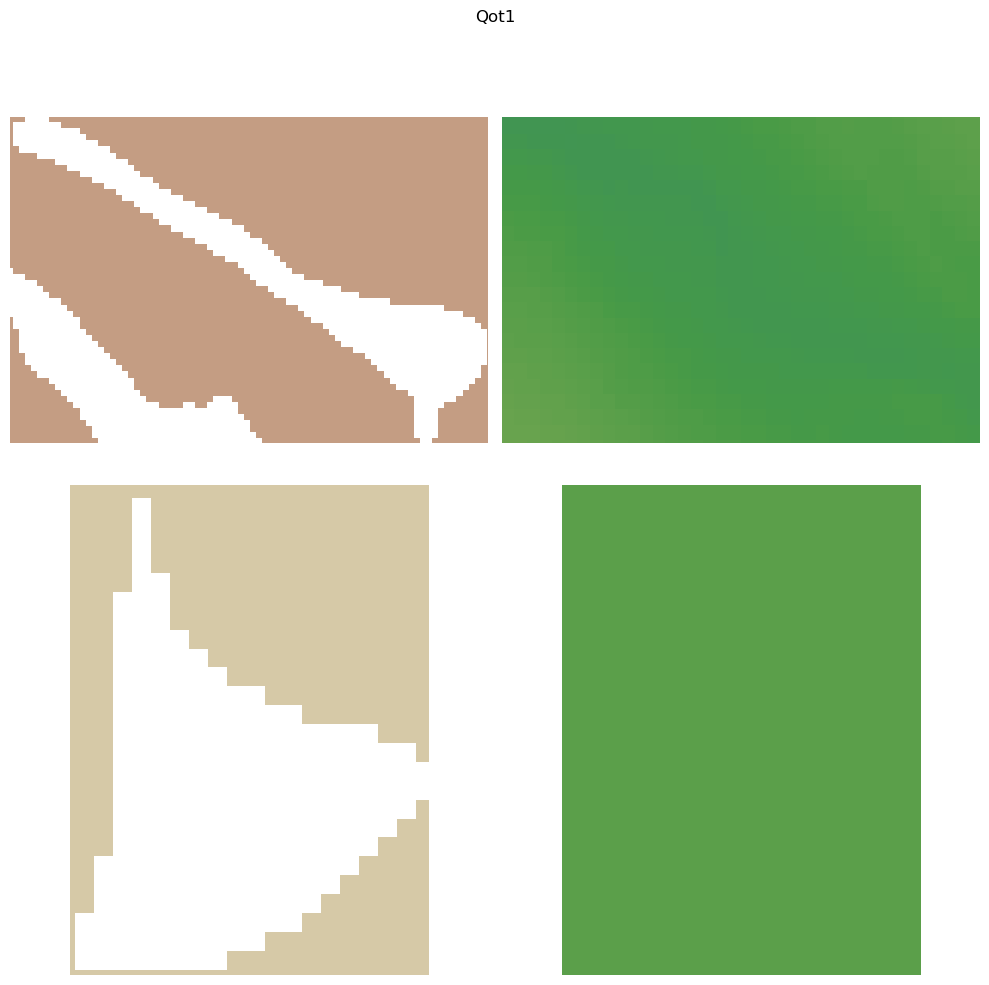

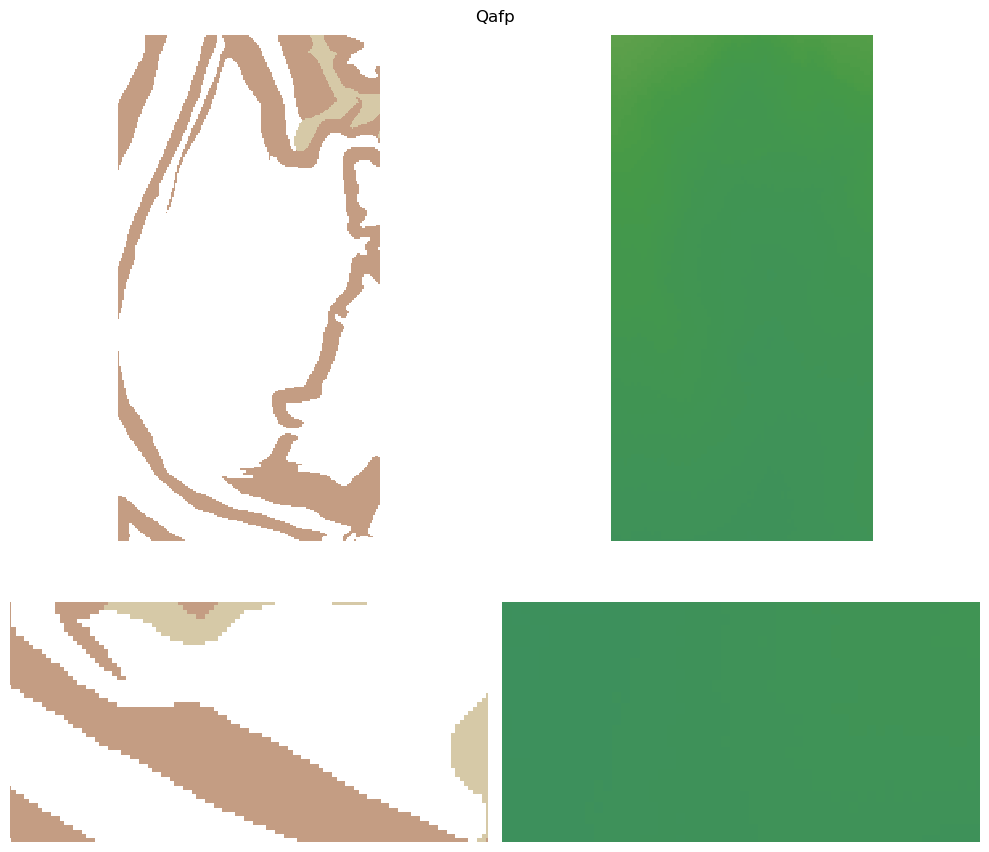

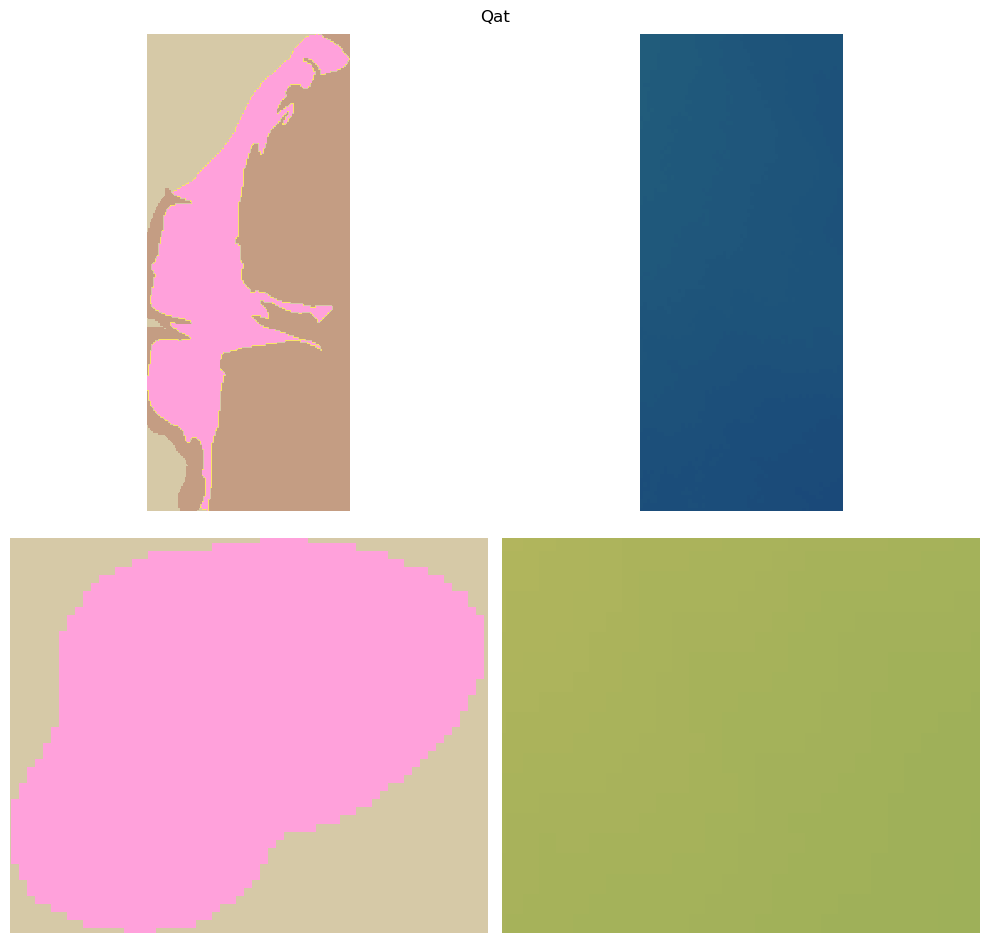

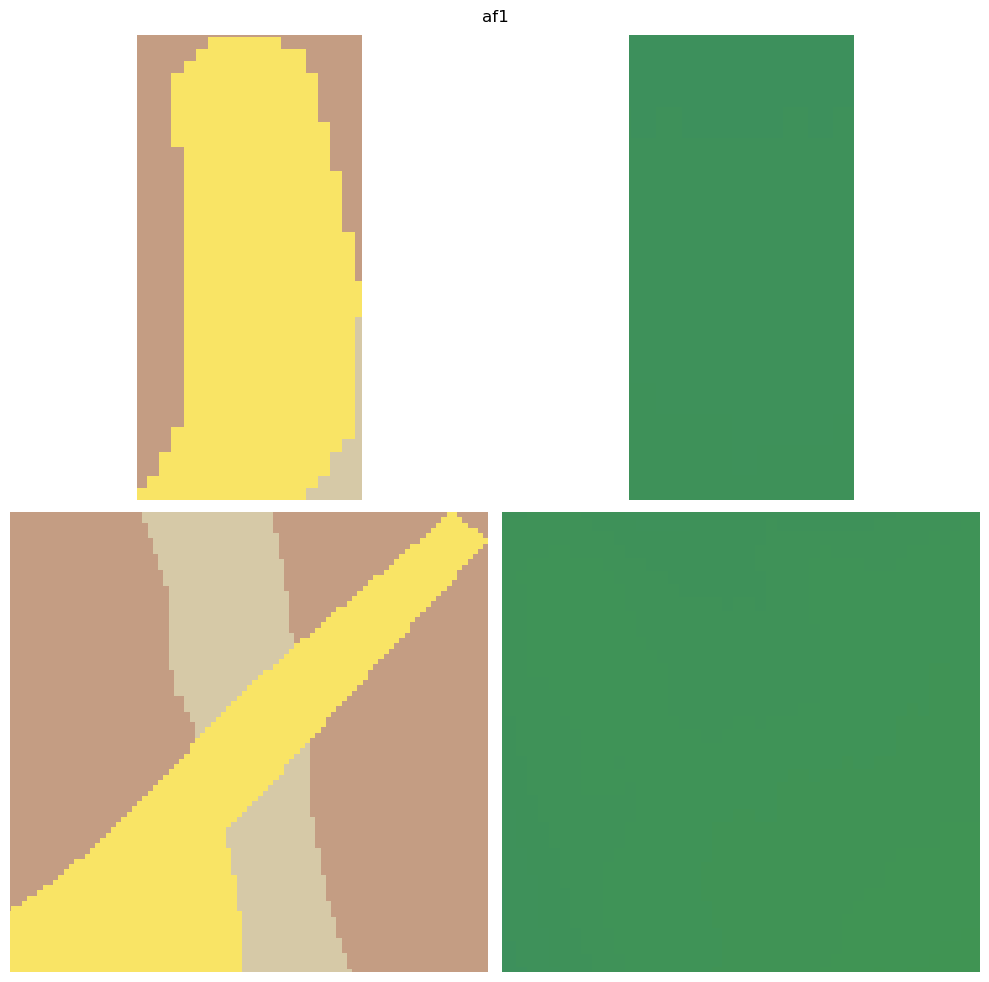

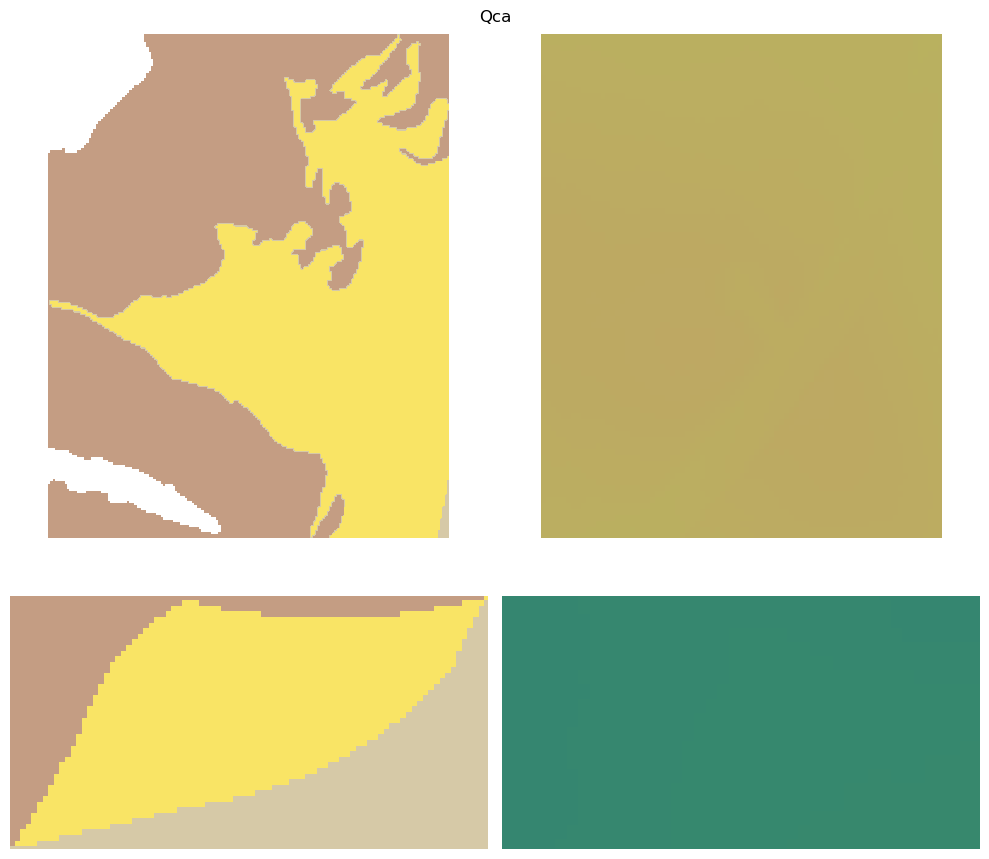

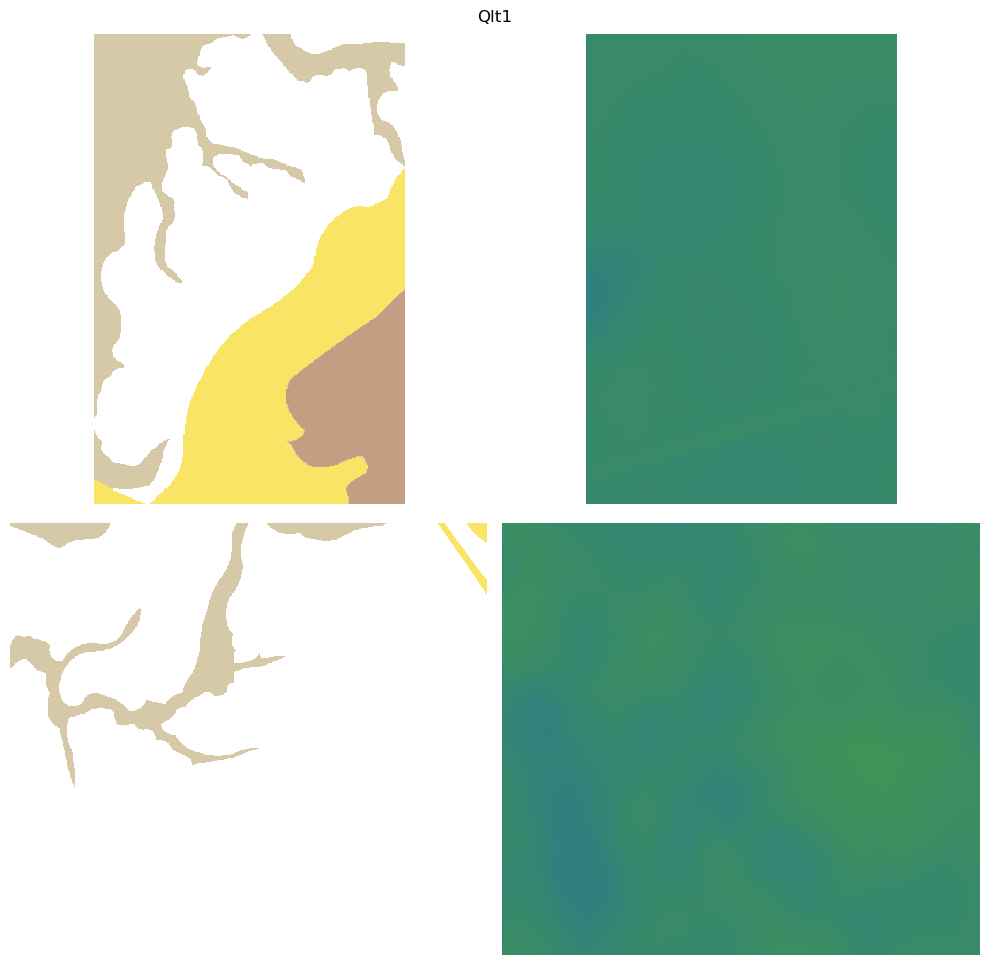

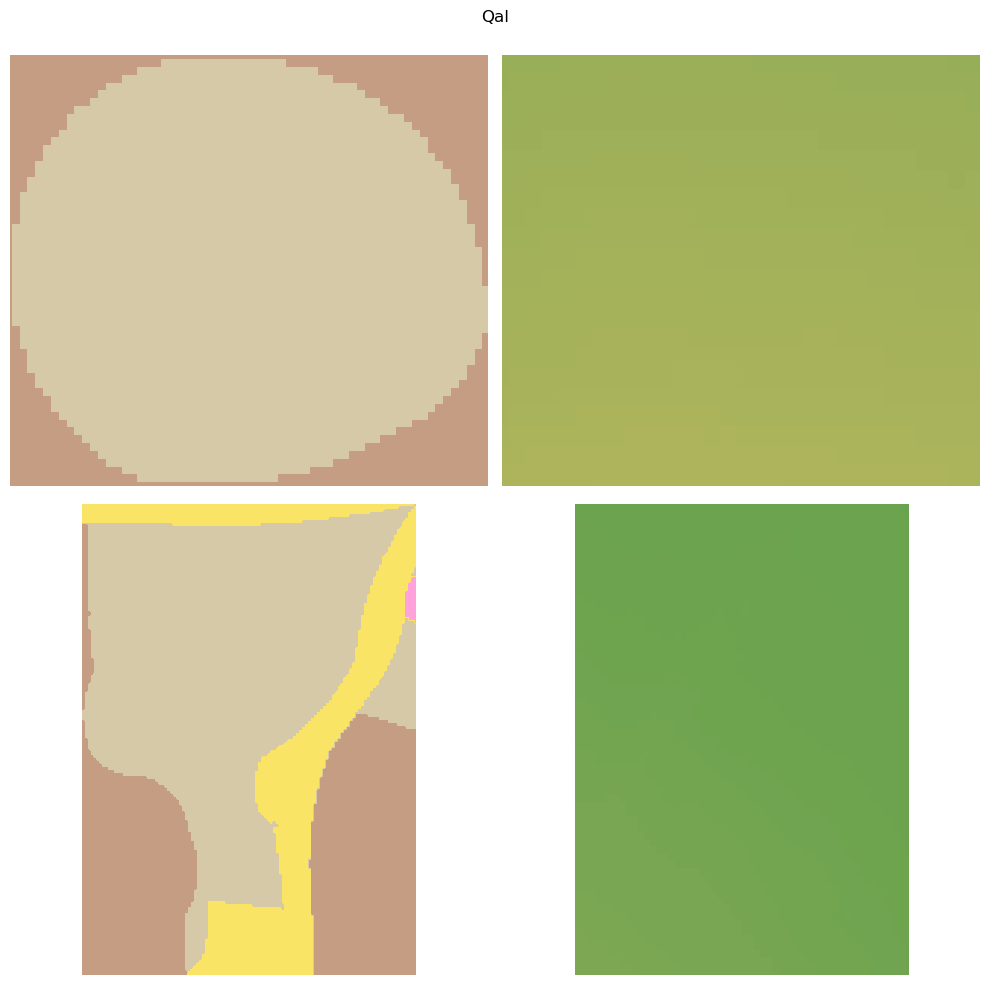

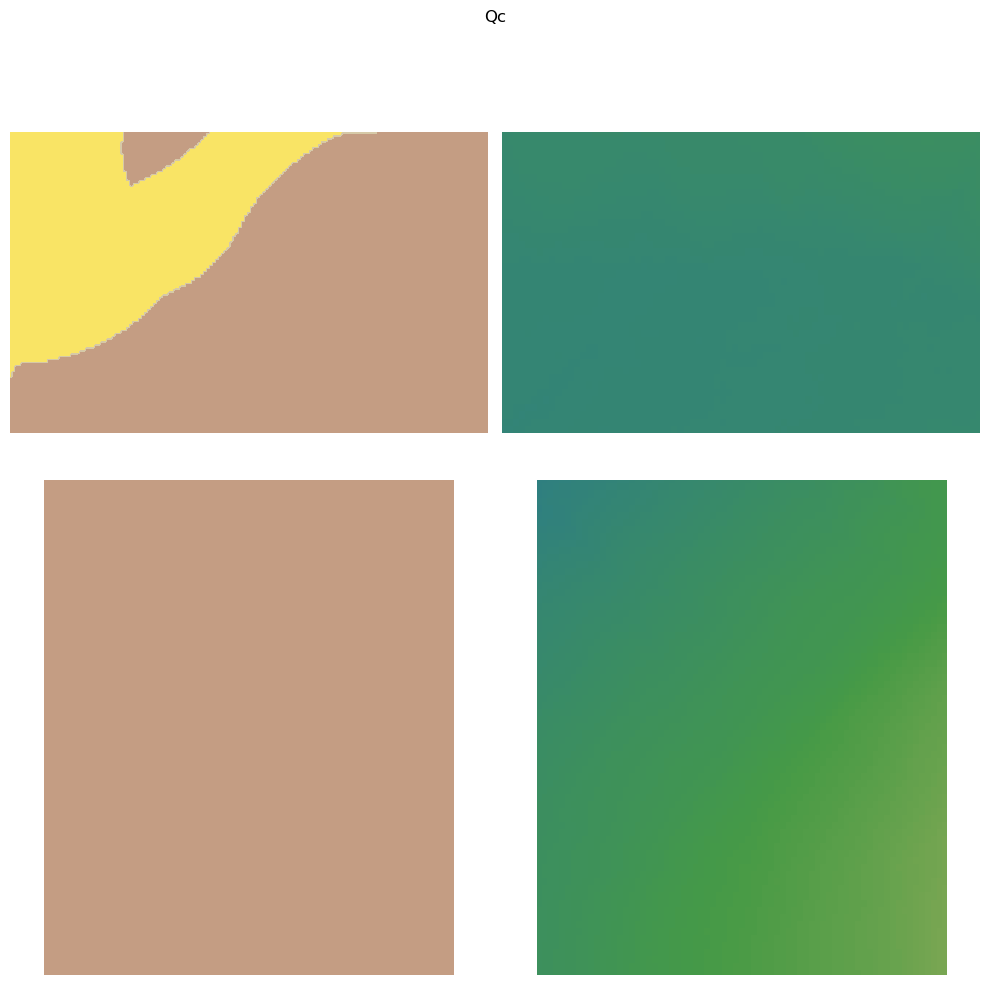

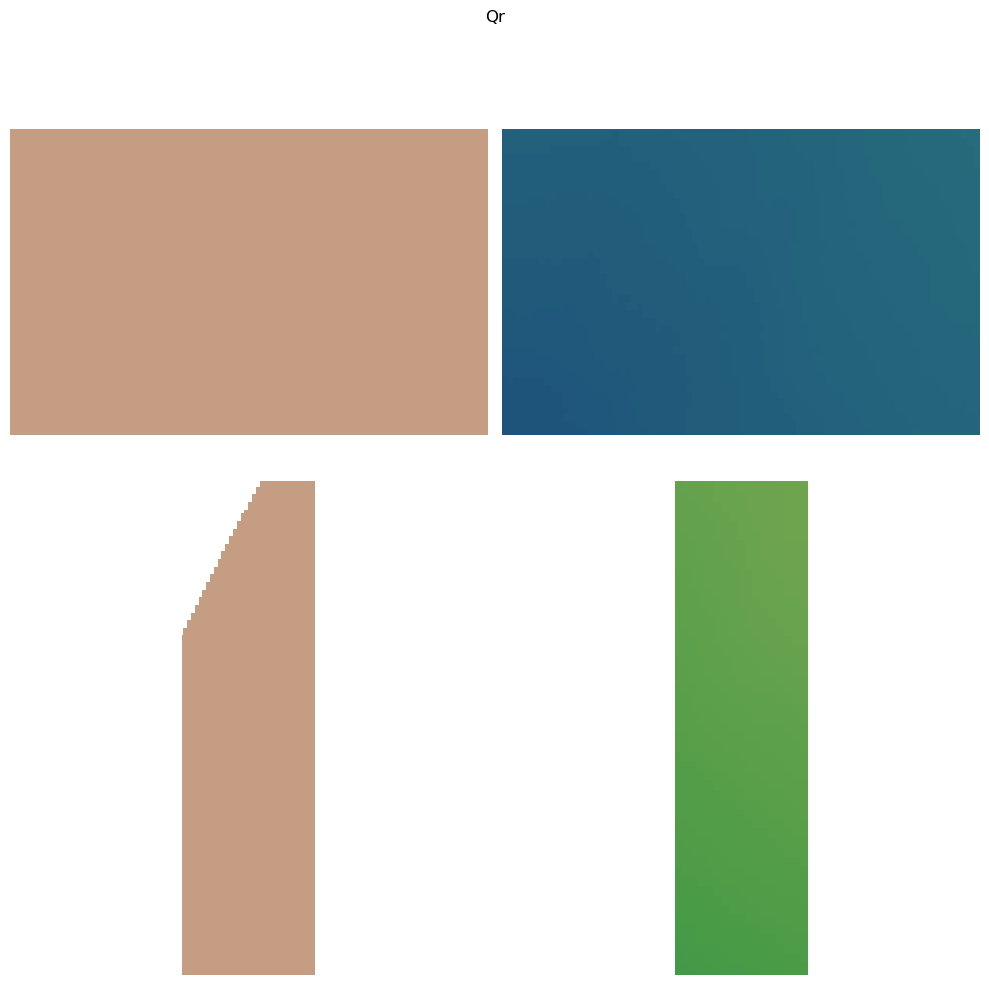

In [81]:
# open geologic map image and plot...
with rasterio.open(hardin_geo_mask_path) as geo:

    # read data (mask nodata values)
    geo_data = geo.read(1, masked=True)

    # Get the image extent
    extent = (geo.bounds.left, geo.bounds.right, geo.bounds.bottom, geo.bounds.top)

    
    with rasterio.open(warren_dem_path) as dem:

        dem_data = dem.read(1, masked=True)



    for unit in gdf['Symbol'].unique():

        mask = gdf['Symbol'] == unit

        gdf_subset = gdf.loc[mask].copy()

        gdf_subset.reset_index(drop=True, inplace=True)

        


        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

        ax = ax.ravel()
        
        random_indices = rng.choice(gdf_subset.index, size=2, replace=False)

        ax[0].imshow(geo_data, cmap=cmap, extent=extent)
        polygon_rand1_bbox = gdf_subset.loc[random_indices[0]].geometry.bounds
        ax[0].set_xlim(polygon_rand1_bbox[0], polygon_rand1_bbox[2])
        ax[0].set_ylim(polygon_rand1_bbox[1], polygon_rand1_bbox[3])
        # ax[0].set_title('Randomly Chosen #1', style='italic')


        ax[1].imshow(dem_data, cmap='gist_earth', extent=extent)
        ax[1].set_xlim(polygon_rand1_bbox[0], polygon_rand1_bbox[2])
        ax[1].set_ylim(polygon_rand1_bbox[1], polygon_rand1_bbox[3])


        ax[2].imshow(geo_data, cmap=cmap, extent=extent)
        polygon_rand2_bbox = gdf_subset.loc[random_indices[1]].geometry.bounds
        ax[2].set_xlim(polygon_rand2_bbox[0], polygon_rand2_bbox[2])
        ax[2].set_ylim(polygon_rand2_bbox[1], polygon_rand2_bbox[3])
        # ax[2].set_title('Randomly Chosen #2', style='italic')


        ax[3].imshow(dem_data, cmap='gist_earth', extent=extent)
        ax[3].set_xlim(polygon_rand2_bbox[0], polygon_rand2_bbox[2])
        ax[3].set_ylim(polygon_rand2_bbox[1], polygon_rand2_bbox[3])



        for axis in ax:
            axis.set_axis_off()

        plt.suptitle(f"{unit}")

        plt.tight_layout()
        plt.show()